# importok + adat

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import pandas as pd
pd.options.mode.chained_assignment = None  
import os
import glob
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, log_loss, confusion_matrix, f1_score
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

In [2]:
with open('model_ready_dict.pickle', 'rb') as handle:
    model_ready_dict = pickle.load(handle)

In [3]:
def convert_decimal_odds_to_probabilities(dfs_dict, odds_columns):

    for key, df in dfs_dict.items():
        for col in odds_columns:
            df[f'prob_{col}'] = 1 / df[col]  
    return dfs_dict

odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
model_ready_dict = convert_decimal_odds_to_probabilities(model_ready_dict, odds)

In [4]:
for key, df in model_ready_dict.items():
    name = key.replace(" ", "_").lower()
    globals()[name] = df

In [45]:
big5 = pd.read_excel("big5_sorted_by_date.xlsx")
big5.drop(columns='Unnamed: 0', inplace=True)

def convert_odds_big5(df, odds_columns):
    for col in odds_columns:
        df[f'prob_{col}'] = 1 / df[col]
    return df

odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market',
        'U2.5_odds_market', 'O2.5_odds_market']
big5 = convert_odds_big5(big5, odds)

# Végeredmény

## PL, full time result

### tuning

In [32]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer

def random_forest_tuning(df, target_col, drop_cols=[]):
    
    """Ez a függvény a hiperparaméterillesztő Random Forest.
    
    df = a tisztított df, 6 lehetőség van: a top 5 liga külön, és egy kombinált df
    target_col = az előrejelezni kívánt változó
    drop_cols = a többi célváltozó, amiket szintén el kell távolítani
    """
    
    df = df.dropna().reset_index(drop=True)

    X = df.drop(columns=[target_col] + drop_cols)
    y = df[target_col]

    """A tanulóhalmaz 80%, a validációs 10%.
    A sorrendiség megmarad, a print parancsok ezt hivatottak leellenőrizni.
    """
    
    train_n = int(round(len(df) * 0.8, 0))
    val_n = int(round(len(df) * 0.1, 0))

    train_set = df.iloc[:train_n]        
    val_set = df.iloc[train_n:train_n + val_n] 

    print(f"tanító halmaz dimenziók: {train_set.shape}")
    print(f"validációs halmaz dimenziók: {val_set.shape}")
        
    print(f"\ntanító halmaz indexek: (i: {train_set.index[0]+1} -> {train_set.index[-1]+1})")
    print(f"validációs halmaz:  (i: {val_set.index[0]+1} -> {val_set.index[-1]+1})")

    X_train, y_train = train_set.drop(columns=[target_col] + drop_cols), train_set[target_col]
    X_val, y_val = val_set.drop(columns=[target_col] + drop_cols), val_set[target_col]

    """A hiperparaméter grid. Próbáltam több hiperparaméterrel,
    de az rengeteg idő volt, és nem érte meg.
    A keresztvalidációs függvény a TimeSeriesSplit(), amely kifejezetten 
    temporális adatokra van kitalálva.
    """
    
    param_space = {
        'n_estimators': Integer(100, 1000),
        'max_depth': Integer(10, 50),       
        'min_samples_split': Integer(2, 20), 
        'min_samples_leaf': Integer(1, 20), 
        'criterion': ['gini', 'entropy'],     
        'max_features': ['sqrt', 'log2']     
    }
    
    rf = RandomForestClassifier(random_state=1)
    
    bayes_search = BayesSearchCV(
        estimator=rf,
        search_spaces=param_space,
        n_iter=30,  
        scoring='f1',  
        refit='f1',
        cv=TimeSeriesSplit(n_splits=5),  
        verbose=0,
        n_jobs=-1,  
        random_state=1
    )

    """A Random Forest algoritmus behívása, validációs halmazra illesztése-
    Továbbá lementem a 15 legfontosabb paramétert, előrejelzést adok a validációs halmazon
    a célváltozóra, és az egyes kimenetelek valószínűségeit is lementjük. 
    
    A kód legvégén egy modell teljeseítményét összegző report és egy konfúziós mx van.
    """
    
    bayes_search.fit(X_train, y_train)  

    best_model = bayes_search.best_estimator_
    best_params = bayes_search.best_params_
    print("\nlegjobb modell hiperparameterei:", best_params)

    y_pred = best_model.predict(X_val)
    val_set = val_set.copy()
    val_set.loc[:, 'Predicted'] = y_pred

    accuracy = accuracy_score(y_val, y_pred)
    print(f"accuracy: {accuracy:.4f}")
    
    y_val_probs = best_model.predict_proba(X_val)
    
    val_set['P_0'] = y_val_probs[:, 0] 
    val_set['P_1'] = y_val_probs[:, 1]  
    
    print("\nösszegzés:")
    print(classification_report(y_val, y_pred))

    plt.figure(figsize=(3, 2))
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="OrRd", xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel("Modell")
    plt.ylabel("Valós")
    plt.show()

    feature_importances = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model.feature_importances_
    }).sort_values(by='importance', ascending=False)
    
    print("\ntop15 valtozo:")
    top_features = feature_importances.head(15)
    print(top_features)
    
    plt.figure(figsize=(5, 3))
    sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')
    plt.xlabel("Változók fontossága")
    plt.ylabel("Változók")
    plt.grid(axis='x')
    plt.show()

    return val_set, best_params, top_features

tanító halmaz dimenziók: (2958, 67)
validációs halmaz dimenziók: (370, 67)

tanító halmaz indexek: (i: 1 -> 2958)
validációs halmaz:  (i: 2959 -> 3328)

legjobb modell hiperparameterei: OrderedDict({'criterion': 'entropy', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 11, 'n_estimators': 900})
accuracy: 0.6649

összegzés:
              precision    recall  f1-score   support

           0       0.64      0.78      0.71       190
           1       0.70      0.54      0.61       180

    accuracy                           0.66       370
   macro avg       0.67      0.66      0.66       370
weighted avg       0.67      0.66      0.66       370



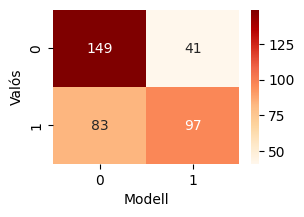


top15 valtozo:
                       feature  importance
53      prob_HomeW_odds_market    0.074298
54      prob_AwayW_odds_market    0.070109
52                     GD_diff    0.034074
55       prob_Draw_odds_market    0.032775
28     away_expected_points_RA    0.030079
31    away_np_xg_difference_RA    0.029195
51      cumulative_points_diff    0.028448
30               away_np_xg_RA    0.028059
13  home_cumulative_goals_diff    0.026684
56       prob_U2.5_odds_market    0.026314
29                  away_xg_RA    0.026270
9     home_np_xg_difference_RA    0.024674
32                away_ppda_RA    0.024124
57       prob_O2.5_odds_market    0.024024
10                home_ppda_RA    0.023342


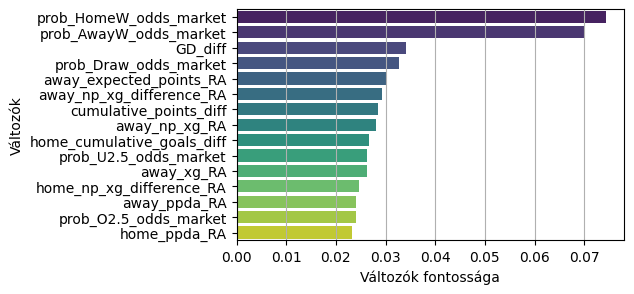

In [33]:
target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

premier_league_tuned_home, premier_league_params_home, premier_league_top_features_home = random_forest_tuning(premier_league,
                                                                                                               target_col,
                                                                                                               drop)

In [ ]:
target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

premier_league_tuned_away, premier_league_params_away, premier_league_top_features_away = random_forest_tuning(premier_league,
                                                                                                               target_col,
                                                                                                               drop)

### tuned model on train+validation

In [14]:
def random_forest_validation(df, target_col, drop_cols=[], best_params={}):

    """
    Ez a második modell: az előzőleg lementett hiperparamétereket (lásd a best_params inputot)
    használja a modell újraillesztéséhez.

    A tanítóhalmaz így a teljes halmaz 90%-a: az eredeti, 80%-os tanítóhalmaz, plusz a 10% validációs.
    A teszthalmaz a maradék 10%, ami pont egy szezon.

    A függvény csak a modellt adja vissza, másra nincs szükség.

    """
    df = df.dropna().reset_index(drop=True)

    X = df.drop(columns=[target_col] + drop_cols)
    y = df[target_col]
    
    train_n = int(round(len(df) * 0.8, 0))
    val_n = int(round(len(df) * 0.1, 0))
    test_n = len(df) - train_n - val_n 
    
    train_set = df.iloc[:train_n]        
    val_set = df.iloc[train_n:train_n + val_n] 
    test_set = df.iloc[train_n + val_n:] 

    train_set = pd.concat([train_set,val_set])

    X_train, y_train = train_set.drop(columns=[target_col] + drop_cols), train_set[target_col]
    X_val, y_val = val_set.drop(columns=[target_col] + drop_cols), val_set[target_col]
                
    rf = RandomForestClassifier(
        n_estimators=best_params.get('n_estimators', 500),
        max_depth=best_params.get('max_depth', 10),
        min_samples_split=best_params.get('min_samples_split', 2),
        min_samples_leaf=best_params.get('min_samples_leaf', 1),
        criterion=best_params.get('criterion', 'entropy'),
        max_features=best_params.get('max_features', 'sqrt'),
        random_state=best_params.get('random_state', 1)
    )
    
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)

    val_set = val_set.copy()
    val_set.loc[:, 'Predicted'] = y_pred

    return rf

### final model, with voting

In [25]:
# def random_forest_final(df, drop_cols_home=[], drop_cols_away=[], best_params_home={}, best_params_away={}):


#     """
#     A végső függvény. Itt hívjuk be az előzőleg megírt Random Forestet.
#     Továbbá itt hajtunk végre egy soft és egy hard votingot.
#     Külön vesszük a hazai és az idegen kimeneteleket előrejelző modellek paramétereit.
#     """
#     df = df.dropna().reset_index(drop=True)

#     rf_home = random_forest_validation(df, "target_home_win", drop_cols_home, best_params_home)
#     rf_away = random_forest_validation(df, "target_away_win", drop_cols_away, best_params_away)

#     X_test = df.tail(int(len(df) * 0.1)).reset_index(drop=True)    
#     X_test = X_test.drop(columns=["target_home_win", "target_away_win"] + drop_cols_home + drop_cols_away)

#     model_home_preds = rf_home.predict(X_test)
#     model_away_preds = rf_away.predict(X_test)

#     df.loc[df.index[-len(X_test):], "model_home"] = model_home_preds
#     df.loc[df.index[-len(X_test):], "model_away"] = model_away_preds

#     """
#     A valószínűségeket a következőképpen definiáljuk:
#     A 2 modell ad egy valószínűséget a kimenetelekre.
#     A home modell azt adja, hogy vagy hazai győzelem, vagy nem
#     Az idegen azt, hogy vagy idegen győzelem, vagy nem.
#     Ebből kikövetkeztethető a döntetlenek implikált valószínűsége.
#     Azért így "körbelövöm" a döntetlent, mert egy olyan modell, ami azt jelzi előre,
#     hogy vagy döntetlen, vagy nem, elképesztően alacsony pontossággal (szakirodalom és saját tesztelés alapján 5-20% kb.) operál.

#     Ezután vesszük az adott sor maximum valószínűségét. Volt néhány esetben negatív vszg,
#     ennek nem örülünk, szóval min. 0-ra lefixáljuk.
#     Mivel ezek összege lehet +1, így ezt skálázzuk úgy, hogy elosztjuk
#     minden kimenetel vszg-ét a teljes vszggel.
#     """
#     prob_home_win = rf_home.predict_proba(X_test)[:, 1]  
#     prob_away_win = rf_away.predict_proba(X_test)[:, 1] 
    
#     prob_home_win = np.maximum(prob_home_win, 0)
#     prob_away_win = np.maximum(prob_away_win, 0)
#     prob_draw = np.maximum(1 - (prob_home_win + prob_away_win), 0)

#     total_prob = prob_home_win + prob_away_win + prob_draw
#     prob_home_win /= total_prob
#     prob_away_win /= total_prob
#     prob_draw /= total_prob

#     df.loc[df.index[-len(X_test):], "prob_home_win"] = prob_home_win
#     df.loc[df.index[-len(X_test):], "prob_away_win"] = prob_away_win
#     df.loc[df.index[-len(X_test):], "prob_draw"] = prob_draw

#     """
#     Kétféle voting mechanizmus van: hard és soft.
#     A legkönnyebb a döntetlenekkel illusztrálni a különbséget.

#     Hardnál döntetlen, ha a két modell szerint egyik csapat sem győzött.
#     Softnál döntetlen, ha a legmagasabb vszg-e a döntetlennek van.

#     Előzetesen az várható, hogy a hard túlbecsüli, a soft pedig nagyon alulbecsüli a döntetleneket, de cserébe
#     sokkal magasabb pontossággal becsli a hazai és idegen győzelmeket. 
#     """
#     def voting_hard(row):
#         if row["model_home"] == 1 and row["model_away"] == 0:
#             return "Home Win"
#         elif row["model_away"] == 1 and row["model_home"] == 0:
#             return "Away Win"
#         elif row["model_home"] == 0 and row["model_away"] == 0:
#             return "Draw"
#         else:
#             return "X"

#     def voting_soft(row):
#         prob_home_win = row['prob_home_win']
#         prob_away_win = row['prob_away_win']
#         prob_draw = row['prob_draw']

#         prob_home_win = max(prob_home_win,0)
#         prob_away_win = max(prob_away_win,0)
#         prob_draw = max(prob_draw,0)

#         if prob_home_win < 0:
#             prob_home_win = 0
#         if prob_away_win < 0:
#             prob_away_win = 0
#         if prob_draw < 0:
#             prob_draw = 0
                        
#         max_prob = max(prob_home_win, prob_away_win, prob_draw)

#         """
#         Itt további feltételekkel lehet variálni, volt olyan, ami javított is a modellen.
        
#         A motiváció a hazai pálya előnyéből jön, továbbá abból, hogy ha 
#         az idegen és a hazai modell is kb. hasonló vszg-et állapít meg az előrejelzett eseményeikre,
#         akkor feltételezhető a döntetlen.
#         Pl. ha a hazai modell 40%-ot ad a hazai GY-re, az idegen pedig 42%-t 
#         az idegen GY-re, akkor feltételezhetjük, hogy a döntetlen vszg-e relatíve magas, azonban a soft voting
#         modell csak 1-0.40-0.42=0.18-as vszg-et fog neki rendelni.

#         1. feltétel a különbség a h és az a közt
#         draw = közel vannak, különben a nagyobb
#         haterertek: mia az a szelessegskala ami a dev halmazosat adja vissza
#         """
        
#         if (max_prob == prob_home_win):# and (prob_home_win > 0.4050) and (abs(prob_home_win - prob_away_win) >= 0.05):
#             return "Home Win"
#         elif (max_prob == prob_away_win):# and (prob_away_win >  0.3332) and (abs(prob_home_win - prob_away_win) >= 0.05):
#             return "Away Win"
#         elif (max_prob == prob_draw):# and (prob_draw > 0.23):
#              return "Draw"
#         else:
#             return "Draw"
    
#     df["test_pred_hard"] = df.apply(voting_hard, axis=1)
#     df["test_pred_soft"] = df.apply(voting_soft, axis=1)

#     plt.figure(figsize=(5, 4))
#     cm_home = confusion_matrix(df["target_home_win"].tail(len(X_test)), model_home_preds)
#     sns.heatmap(cm_home, annot=True, fmt="d", cmap="OrRd", xticklabels=['Nem hazai W', 'Hazai W'], yticklabels=['Nem hazai W', 'Hazai W'])
#     plt.xlabel("Előrejelzett")
#     plt.ylabel("Valós")
#     plt.title("Hazai model")
#     plt.show()

#     plt.figure(figsize=(5, 4))
#     cm_away = confusion_matrix(df["target_away_win"].tail(len(X_test)), model_away_preds)
#     sns.heatmap(cm_away, annot=True, fmt="d", cmap="Blues", xticklabels=['Nem idegen W', 'Idegen W'], yticklabels=['Nem idegen W', 'Idegen W'])
#     plt.xlabel("Előrejelzett")
#     plt.ylabel("Valós")
#     plt.title("Idegen modell")
#     plt.show()

#     return df, rf_home, rf_away

In [43]:
def random_forest_final(df, drop_cols_home=[], drop_cols_away=[], best_params_home={}, best_params_away={}):
    df = df.dropna().reset_index(drop=True)

    rf_home = random_forest_validation(df, "target_home_win", drop_cols_home, best_params_home)
    rf_away = random_forest_validation(df, "target_away_win", drop_cols_away, best_params_away)

    X_test = df.tail(int(len(df) * 0.1)).reset_index(drop=True)    
    X_test = X_test.drop(columns=["target_home_win", "target_away_win"] + drop_cols_home + drop_cols_away)

    model_home_preds = rf_home.predict(X_test)
    model_away_preds = rf_away.predict(X_test)

    df.loc[df.index[-len(X_test):], "model_home"] = model_home_preds
    df.loc[df.index[-len(X_test):], "model_away"] = model_away_preds

    prob_home_win = rf_home.predict_proba(X_test)[:, 1]  
    prob_away_win = rf_away.predict_proba(X_test)[:, 1] 
    
    prob_home_win = np.maximum(prob_home_win, 0)
    prob_away_win = np.maximum(prob_away_win, 0)
    prob_draw = np.maximum(1 - (prob_home_win + prob_away_win), 0)

    total_prob = prob_home_win + prob_away_win + prob_draw
    prob_home_win /= total_prob
    prob_away_win /= total_prob
    prob_draw /= total_prob

    df.loc[df.index[-len(X_test):], "prob_home_win"] = prob_home_win
    df.loc[df.index[-len(X_test):], "prob_away_win"] = prob_away_win
    df.loc[df.index[-len(X_test):], "prob_draw"] = prob_draw

    best_f1_macro = 0
    best_threshold = 0.15
    best_secondary_threshold = 0.4
    thresholds = np.arange(0.01, 0.20, 0.01)
    secondary_thresholds = np.arange(0.3, 0.6, 0.01)
    
    for threshold in thresholds:
        for secondary_threshold in secondary_thresholds:
            predictions = []
            for i in range(len(X_test)):
                home_prob = prob_home_win[i]
                away_prob = prob_away_win[i]
                
                if abs(home_prob - away_prob) < threshold and max(home_prob, away_prob) < secondary_threshold:
                    predictions.append("Draw")
                elif home_prob > away_prob:
                    predictions.append("Home Win")
                else:
                    predictions.append("Away Win")
            
            true_outcomes = []
            for i in range(len(X_test)):
                if df.iloc[-len(X_test) + i]["target_home_win"] == 1:
                    true_outcomes.append("Home Win")
                elif df.iloc[-len(X_test) + i]["target_away_win"] == 1:
                    true_outcomes.append("Away Win")
                else:
                    true_outcomes.append("Draw")
            
            f1_macro = f1_score(true_outcomes, predictions, average='macro')
            
            if f1_macro > best_f1_macro:
                best_f1_macro = f1_macro
                best_threshold = threshold
                best_secondary_threshold = secondary_threshold
    
    df.loc[df.index[-len(X_test):], "best_threshold"] = best_threshold
    df.loc[df.index[-len(X_test):], "best_secondary_threshold"] = best_secondary_threshold
    
    def voting_hard(row):
        if row["model_home"] == 1 and row["model_away"] == 0:
            return "Home Win"
        elif row["model_away"] == 1 and row["model_home"] == 0:
            return "Away Win"
        elif row["model_home"] == 0 and row["model_away"] == 0:
            return "Draw"
        elif row["model_home"] == 1 and row["model_away"] == 1:
            return "Home Win"
        else:
            return "-"
            
    def voting_soft(row):
        prob_home_win = row['prob_home_win']
        prob_away_win = row['prob_away_win']
        threshold = row['best_threshold']
        secondary_threshold = row['best_secondary_threshold']
        
        if abs(prob_home_win - prob_away_win) < threshold and max(prob_home_win, prob_away_win) < secondary_threshold:
            return "Draw"
        elif prob_home_win > prob_away_win:
            return "Home Win"
        elif prob_home_win < prob_away_win:
            return "Away Win"
        else:
            return "-"
    
    df["test_pred_hard"] = df.apply(voting_hard, axis=1)
    df["test_pred_soft"] = df.apply(voting_soft, axis=1)
    
    plt.figure(figsize=(5, 4))
    cm_home = confusion_matrix(df["target_home_win"].tail(len(X_test)), model_home_preds)
    sns.heatmap(cm_home, annot=True, fmt="d", cmap="Blues", xticklabels=['Nem hazai Gy', 'Hazai Gy'], yticklabels=['Nem hazai Gy', 'Hazai Gy'])
    plt.xlabel("Modell")
    plt.ylabel("Valós")
    plt.title("Hazai modell")
    plt.show()
    
    plt.figure(figsize=(5, 4))
    cm_away = confusion_matrix(df["target_away_win"].tail(len(X_test)), model_away_preds)
    sns.heatmap(cm_away, annot=True, fmt="d", cmap="Blues", xticklabels=['Nem vendég Gy', 'Vendég Gy'], yticklabels=['Nem vendég Gy', 'Vendég Gy'])
    plt.xlabel("Modell")
    plt.ylabel("Valós")
    plt.title("Vendég modell")
    plt.show()
    
    print(f"legjobb threshold #1: {best_threshold:.2f}")
    print(f"legjobb threshold #2: {best_secondary_threshold:.2f}")

    return df, rf_home, rf_away


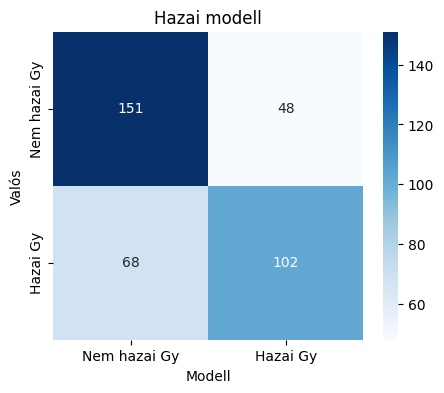

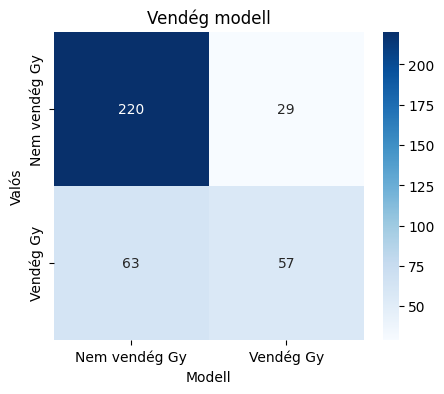

legjobb threshold #1: 0.17
legjobb threshold #2: 0.52


In [18]:
# drop_cols_home =['target_away_win', 'target_draw','target_o2.5']

drop_cols_home =['target_away_win', 'target_draw','target_o2.5',
                 'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# drop_cols_away =['target_home_win', 'target_draw','target_o2.5']

drop_cols_away =['target_home_win', 'target_draw','target_o2.5',
                'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

test_predictions_pl, random_forest_home_pl, random_forest_away_pl = random_forest_final(premier_league,
                                                                                         drop_cols_home, drop_cols_away,
                                                                                         premier_league_params_home,premier_league_params_away)

In [22]:
def process_predictions(df):
    df = df.dropna()

    df.loc[:, 'odds_draw_model'] = 1 / df['prob_draw']
    df.loc[:, 'odds_away_win_model'] = 1 / df['prob_away_win']
    df.loc[:, 'odds_home_win_model'] = 1 / df['prob_home_win']

    df.loc[:, 'FTR'] = 0  
    df.loc[df['target_home_win'] == 1, 'FTR'] = 1  
    df.loc[df['target_away_win'] == 1, 'FTR'] = 2  

    df.loc[:, 'test_pred_numeric_hard'] = 0
    df.loc[df['test_pred_hard'] == "Home Win", 'test_pred_numeric_hard'] = 1  
    df.loc[df['test_pred_hard'] == "Away Win", 'test_pred_numeric_hard'] = 2 
    df.loc[df['test_pred_hard'] == "Draw", 'test_pred_numeric_hard'] = 0  

    df.loc[:, 'test_pred_numeric_soft'] = 0
    df.loc[df['test_pred_soft'] == "Home Win", 'test_pred_numeric_soft'] = 1  
    df.loc[df['test_pred_soft'] == "Away Win", 'test_pred_numeric_soft'] = 2 
    df.loc[df['test_pred_soft'] == "Draw", 'test_pred_numeric_soft'] = 0 

    selected_columns = [
        'target_home_win', 'target_away_win', 'target_draw', 'FTR',
        'test_pred_hard', 'test_pred_soft',
        'test_pred_numeric_hard', 'test_pred_numeric_soft'
    ]
    result_df = df[selected_columns]

    pred_odds = df[['FTR', 'test_pred_numeric_hard', 'test_pred_numeric_soft',
                    'HomeW_odds_market', 'odds_home_win_model',
                    'AwayW_odds_market', 'odds_away_win_model',
                    'Draw_odds_market', 'odds_draw_model']]

    return pred_odds

In [23]:
pred_odds_pl = process_predictions(test_predictions_pl)

In [24]:
def evaluation(pred_odds):
    print("Summary for HARD VOTING model")
    cm_hard = confusion_matrix(pred_odds["FTR"], pred_odds["test_pred_numeric_hard"])
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm_hard, annot=True, fmt="d", cmap="Blues", 
                xticklabels=['X', 'Hazai GY', 'Idegen GY'], 
                yticklabels=['X', 'Hazai GY', 'Idegen GY'])
    plt.xlabel("Model")
    plt.ylabel("Valós")
    plt.title("Konfúziós mx (Hard Voting)")
    plt.show()
    accuracy_hard = accuracy_score(pred_odds["FTR"], pred_odds["test_pred_numeric_hard"])
    report_hard = classification_report(pred_odds["FTR"], pred_odds["test_pred_numeric_hard"], digits=4)
    print("\nClassification Report (Hard Voting):\n", report_hard)

    print("\nSummary for SOFT VOTING model")
    cm_soft = confusion_matrix(pred_odds["FTR"], pred_odds["test_pred_numeric_soft"])
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm_soft, annot=True, fmt="d", cmap="Blues", 
                xticklabels=['X', 'Hazai GY', 'Idegen GY'], 
                yticklabels=['X', 'Hazai GY', 'Idegen GY'])
    plt.xlabel("Model")
    plt.ylabel("Valós")
    plt.title("Konfúziós mx (Soft Voting)")
    plt.show()
    accuracy_soft = accuracy_score(pred_odds["FTR"], pred_odds["test_pred_numeric_soft"])
    report_soft = classification_report(pred_odds["FTR"], pred_odds["test_pred_numeric_soft"], digits=4)
    print("\nClassification Report (Soft Voting):\n", report_soft)

Summary for HARD VOTING model


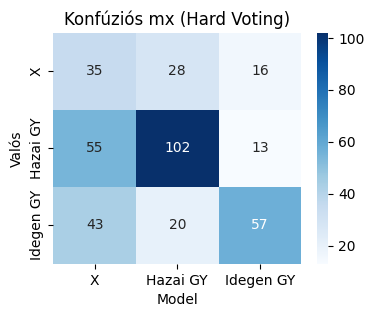


Classification Report (Hard Voting):
               precision    recall  f1-score   support

           0     0.2632    0.4430    0.3302        79
           1     0.6800    0.6000    0.6375       170
           2     0.6628    0.4750    0.5534       120

    accuracy                         0.5257       369
   macro avg     0.5353    0.5060    0.5070       369
weighted avg     0.5852    0.5257    0.5444       369


Summary for SOFT VOTING model


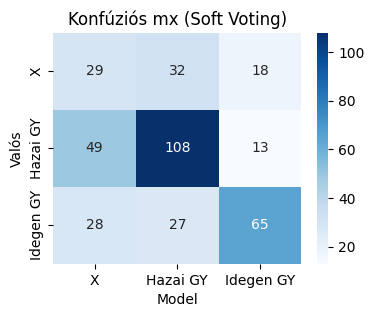


Classification Report (Soft Voting):
               precision    recall  f1-score   support

           0     0.2736    0.3671    0.3135        79
           1     0.6467    0.6353    0.6409       170
           2     0.6771    0.5417    0.6019       120

    accuracy                         0.5474       369
   macro avg     0.5325    0.5147    0.5188       369
weighted avg     0.5767    0.5474    0.5581       369



In [25]:
evaluation(pred_odds_pl)

### fogadás, ROI

In [26]:
def betting_randomforest(df, stake=1):

    """
    Ezzel a fügvénnyel számolom ki a befektetés kamatát.
    Ezt külön megteszem a hard és a soft votingra.
    A tét fix, ezen lehet javítani valamilyen közgazdaságtanból származtatott optimalizálással.
    A profit definíciója a következő:
    
        (tét * historikus szorzó) - tét
    Felszummázzuk, majd a százalékos ROI-t a következőképpen kapjuk meg:
    
        (egyes meccsek profitjai felszummázva / összes elköltött pénz) * 100
    """
    df = df.copy() 

    df['Profit_hard'] = 0
    df['Profit_hard'] = df.apply(
        lambda row: (stake * row['HomeW_odds_market'] - stake) if row['test_pred_numeric_hard'] == 1 and row['FTR'] == 1 else
                     (stake * row['AwayW_odds_market'] - stake) if row['test_pred_numeric_hard'] == 2 and row['FTR'] == 2 else
                     (stake * row['Draw_odds_market'] - stake) if row['test_pred_numeric_hard'] == 0 and row['FTR'] == 0 else
                     -stake, axis=1
    )

    total_profit_hard = df['Profit_hard'].sum()
    total_bets = len(df)

    roi_hard = (total_profit_hard / (total_bets * stake)) * 100
    
    print(f"ROI hard : {roi_hard:.2f}%")

    df['Profit_soft'] = 0
    df['Profit_soft'] = df.apply(
        lambda row: (stake * row['HomeW_odds_market'] - stake) if row['test_pred_numeric_soft'] == 1 and row['FTR'] == 1 else
                     (stake * row['AwayW_odds_market'] - stake) if row['test_pred_numeric_soft'] == 2 and row['FTR'] == 2 else
                     (stake * row['Draw_odds_market'] - stake) if row['test_pred_numeric_soft'] == 0 and row['FTR'] == 0 else
                     -stake, axis=1
    )

    total_profit_soft = df['Profit_soft'].sum()
    total_bets = len(df)

    roi_soft = (total_profit_soft / (total_bets * stake)) * 100

    print(f"ROI soft : {roi_soft:.2f}%")

    df_profit_hard = df[df['FTR'] == df['test_pred_numeric_hard']]
    df_loss_hard = df[df['FTR'] != df['test_pred_numeric_hard']]
    
    df_profit_soft = df[df['FTR'] == df['test_pred_numeric_soft']]
    df_loss_soft = df[df['FTR'] != df['test_pred_numeric_soft']]

    return roi_hard,roi_soft, df_profit_hard, df_loss_hard,df_profit_soft,df_loss_soft,df

In [27]:
roi_hard,roi_soft, df_profit_hard, df_loss_hard,df_profit_soft,df_loss_soft,pred_odds_soft = betting_randomforest(pred_odds_pl,
                                                                                                                  stake=1)

ROI hard : 1.71%
ROI soft : 3.80%


Válassz(1 vagy 2):
1 - Hard votingos ROI
2 - Soft votingos ROI
 1


>0% profit 17 fordulóban


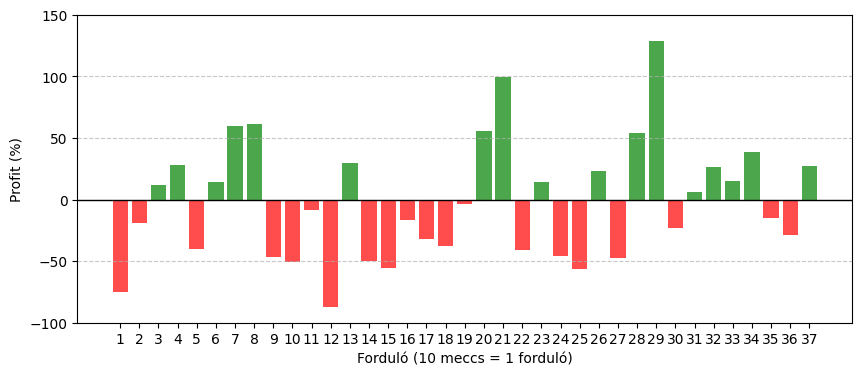

In [105]:
def ROI_sim_per_round(df, stake=1, round_size=int):
    
    df = df.copy().reset_index(drop=True)
    
    valasztas = input("Válassz(1 vagy 2):\n1 - Hard votingos ROI\n2 - Soft votingos ROI\n")
    if valasztas == "1":
        profit_column = "Profit_hard"
    elif valasztas == "2":
        profit_column = "Profit_soft"
    else:
        print("Csak 1 vagy 2 lehet az input")
        return
    
    df['Round'] = (df.index // round_size) + 1  
    roi_per_round = df.groupby('Round').agg({profit_column: 'sum'})
    roi_per_round['Total_Bets'] = df.groupby('Round').size()
    roi_per_round['ROI'] = (roi_per_round[profit_column] / (roi_per_round['Total_Bets'] * stake)) * 100

        
    positive_rounds = (roi_per_round['ROI'] > 0).sum()
    
    print(f'>0% profit {positive_rounds} fordulóban')

    colors = ['red' if roi < 0 else 'green' for roi in roi_per_round['ROI']]
    plt.figure(figsize=(10, 4))
    plt.bar(roi_per_round.index, roi_per_round['ROI'], color=colors, alpha=0.7)
    plt.xlabel(f'Forduló ({round_size} meccs = 1 forduló)')
    plt.ylabel('Profit (%)')
    # plt.title(f'Fogadási szimuláció, 2023-2024-es teszt szezon')
    plt.axhline(0, color='black', linewidth=1)
    plt.xticks(roi_per_round.index)  
    plt.ylim(-100, 150)  # Set y-axis limit
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # plt.savefig(r'abrak/PL_soft_ROI.jpg', format='jpg', dpi=300)
    plt.savefig(r'abrak/PL_hard_ROI.jpg', format='jpg', dpi=300)
    plt.show()

ROI_sim_per_round(pred_odds_soft, round_size=10)

## Bundesliga, full time result

tanító halmaz dimenziók: (2376, 67)
validációs halmaz dimenziók: (297, 67)

tanító halmaz indexek: (i: 1 -> 2376)
validációs halmaz:  (i: 2377 -> 2673)

legjobb modell hiperparameterei: OrderedDict({'criterion': 'gini', 'max_depth': 45, 'max_features': 'log2', 'min_samples_leaf': 16, 'min_samples_split': 3, 'n_estimators': 675})
accuracy: 0.6128

összegzés:
              precision    recall  f1-score   support

           0       0.61      0.76      0.67       156
           1       0.63      0.45      0.53       141

    accuracy                           0.61       297
   macro avg       0.62      0.61      0.60       297
weighted avg       0.62      0.61      0.60       297



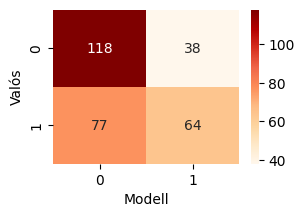


top15 valtozo:
                       feature  importance
54      prob_AwayW_odds_market    0.087415
53      prob_HomeW_odds_market    0.086866
52                     GD_diff    0.041945
51      cumulative_points_diff    0.036036
6      home_expected_points_RA    0.031175
13  home_cumulative_goals_diff    0.028922
9     home_np_xg_difference_RA    0.028610
30               away_np_xg_RA    0.028127
55       prob_Draw_odds_market    0.027970
31    away_np_xg_difference_RA    0.026740
11    home_deep_completions_RA    0.025939
7                   home_xg_RA    0.025220
28     away_expected_points_RA    0.024734
2                home_shots_RA    0.023660
35  away_cumulative_goals_diff    0.022968


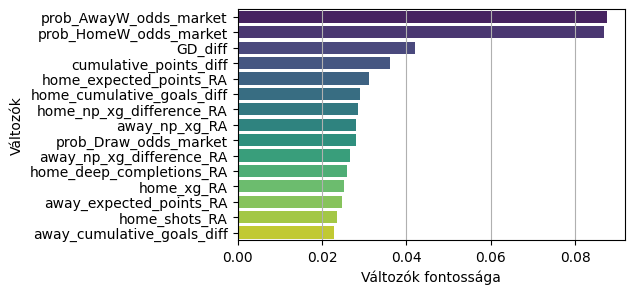

In [35]:
target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

bundesliga_tuned_home, bundesliga_params_home, bundesliga_top_features_home = random_forest_tuning(
    bundesliga,
    target_col,
    drop)

tanító halmaz dimenziók: (2376, 67)
validációs halmaz dimenziók: (297, 67)

tanító halmaz indexek: (i: 1 -> 2376)
validációs halmaz:  (i: 2377 -> 2673)

legjobb modell hiperparameterei: OrderedDict({'criterion': 'gini', 'max_depth': 13, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 19, 'n_estimators': 747})
accuracy: 0.7273

összegzés:
              precision    recall  f1-score   support

           0       0.74      0.95      0.83       214
           1       0.54      0.16      0.24        83

    accuracy                           0.73       297
   macro avg       0.64      0.55      0.54       297
weighted avg       0.69      0.73      0.67       297



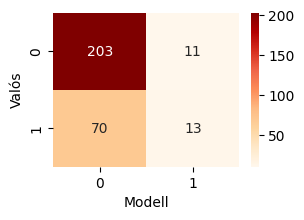


top15 valtozo:
                       feature  importance
53      prob_HomeW_odds_market    0.077359
54      prob_AwayW_odds_market    0.070891
52                     GD_diff    0.038651
31    away_np_xg_difference_RA    0.033562
51      cumulative_points_diff    0.031590
55       prob_Draw_odds_market    0.030734
9     home_np_xg_difference_RA    0.027102
35  away_cumulative_goals_diff    0.027081
13  home_cumulative_goals_diff    0.025783
28     away_expected_points_RA    0.025727
6      home_expected_points_RA    0.024590
33    away_deep_completions_RA    0.024067
8                home_np_xg_RA    0.024023
30               away_np_xg_RA    0.023609
7                   home_xg_RA    0.023083


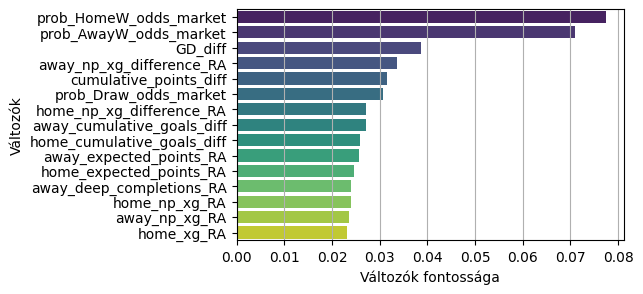

In [36]:
target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

bundesliga_tuned_away, bundesliga_params_away, bundesliga_top_features_away = random_forest_tuning(
    bundesliga,
    target_col,
    drop)

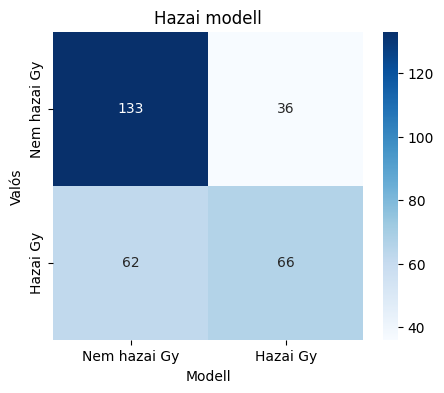

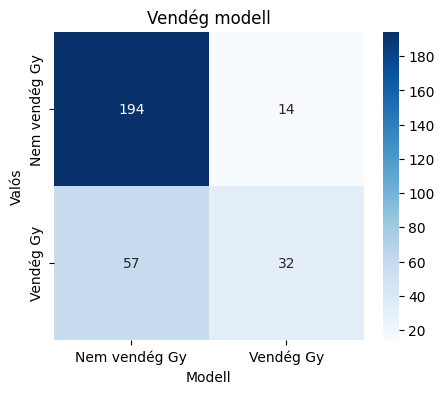

legjobb threshold #1: 0.19
legjobb threshold #2: 0.47


In [106]:
# drop_cols_home =['target_away_win', 'target_draw','target_o2.5']

drop_cols_home =['target_away_win', 'target_draw','target_o2.5',
                 'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# drop_cols_away =['target_home_win', 'target_draw','target_o2.5']

drop_cols_away =['target_home_win', 'target_draw','target_o2.5',
                'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']


test_predictions_bundesliga, random_forest_home_bundesliga, random_forest_away_bundesliga = random_forest_final(
    bundesliga,
    drop_cols_home,
    drop_cols_away,
    bundesliga_params_home,
    bundesliga_params_away
)

In [107]:
pred_odds_bundesliga = process_predictions(test_predictions_bundesliga)

Summary for HARD VOTING model


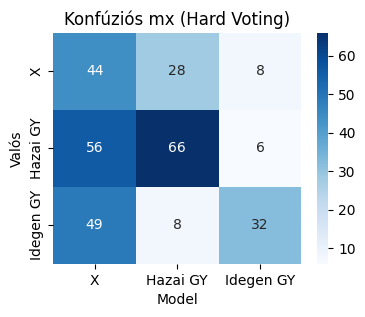


Classification Report (Hard Voting):
               precision    recall  f1-score   support

           0     0.2953    0.5500    0.3843        80
           1     0.6471    0.5156    0.5739       128
           2     0.6957    0.3596    0.4741        89

    accuracy                         0.4781       297
   macro avg     0.5460    0.4751    0.4774       297
weighted avg     0.5669    0.4781    0.4929       297


Summary for SOFT VOTING model


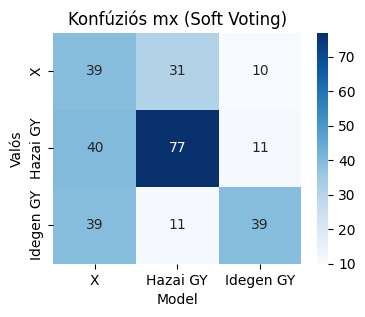


Classification Report (Soft Voting):
               precision    recall  f1-score   support

           0     0.3305    0.4875    0.3939        80
           1     0.6471    0.6016    0.6235       128
           2     0.6500    0.4382    0.5235        89

    accuracy                         0.5219       297
   macro avg     0.5425    0.5091    0.5136       297
weighted avg     0.5627    0.5219    0.5317       297



In [108]:
evaluation(pred_odds_bundesliga)

In [109]:
roi_hard,roi_soft, df_profit_hard, df_loss_hard,df_profit_soft,df_loss_soft,pred_odds_soft = betting_randomforest(pred_odds_bundesliga,
                                                                                                                  stake=500)

ROI hard : 2.74%
ROI soft : 9.31%


Válassz(1 vagy 2):
1 - Hard votingos ROI
2 - Soft votingos ROI
 1


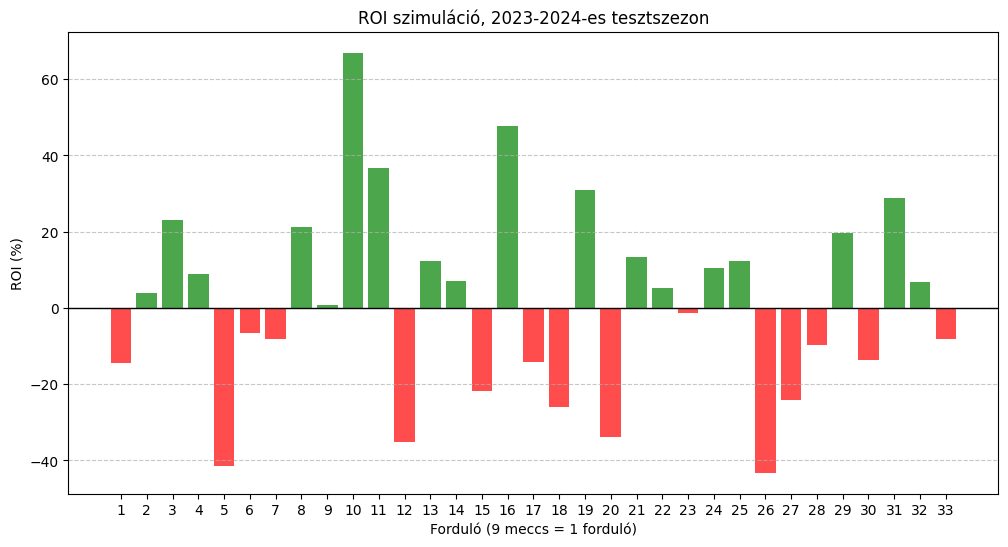

In [55]:
ROI_sim_per_round(pred_odds_soft, round_size=9)

## Serie A, full time result

tanító halmaz dimenziók: (2862, 67)
validációs halmaz dimenziók: (358, 67)

tanító halmaz indexek: (i: 1 -> 2862)
validációs halmaz:  (i: 2863 -> 3220)

legjobb modell hiperparameterei: OrderedDict({'criterion': 'entropy', 'max_depth': 23, 'max_features': 'sqrt', 'min_samples_leaf': 13, 'min_samples_split': 5, 'n_estimators': 1000})
accuracy: 0.6397

összegzés:
              precision    recall  f1-score   support

           0       0.66      0.76      0.71       205
           1       0.60      0.48      0.53       153

    accuracy                           0.64       358
   macro avg       0.63      0.62      0.62       358
weighted avg       0.63      0.64      0.63       358



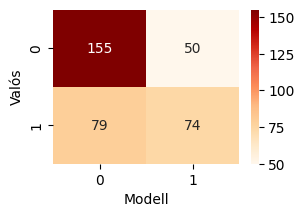


top15 valtozo:
                       feature  importance
53      prob_HomeW_odds_market    0.118744
54      prob_AwayW_odds_market    0.107191
52                     GD_diff    0.044592
55       prob_Draw_odds_market    0.043890
51      cumulative_points_diff    0.040183
28     away_expected_points_RA    0.028011
31    away_np_xg_difference_RA    0.027776
9     home_np_xg_difference_RA    0.025799
6      home_expected_points_RA    0.024054
13  home_cumulative_goals_diff    0.022859
35  away_cumulative_goals_diff    0.020989
10                home_ppda_RA    0.019914
29                  away_xg_RA    0.019680
7                   home_xg_RA    0.019280
32                away_ppda_RA    0.019259


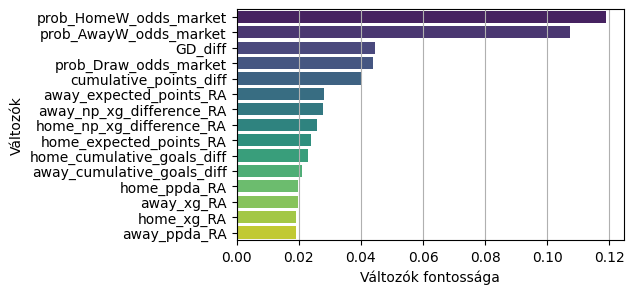

In [37]:
target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

serie_a_tuned_home, serie_a_params_home, serie_a_top_features_home = random_forest_tuning(serie_a,
                                                                                          target_col,
                                                                                          drop)

tanító halmaz dimenziók: (2862, 67)
validációs halmaz dimenziók: (358, 67)

tanító halmaz indexek: (i: 1 -> 2862)
validációs halmaz:  (i: 2863 -> 3220)

legjobb modell hiperparameterei: OrderedDict({'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 730})
accuracy: 0.7179

összegzés:
              precision    recall  f1-score   support

           0       0.76      0.86      0.81       245
           1       0.57      0.41      0.48       113

    accuracy                           0.72       358
   macro avg       0.67      0.63      0.64       358
weighted avg       0.70      0.72      0.70       358



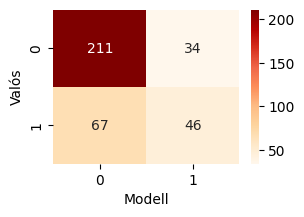


top15 valtozo:
                       feature  importance
53      prob_HomeW_odds_market    0.091952
54      prob_AwayW_odds_market    0.081797
52                     GD_diff    0.041303
51      cumulative_points_diff    0.034606
31    away_np_xg_difference_RA    0.028326
55       prob_Draw_odds_market    0.027706
35  away_cumulative_goals_diff    0.026206
28     away_expected_points_RA    0.025469
10                home_ppda_RA    0.023557
33    away_deep_completions_RA    0.023542
13  home_cumulative_goals_diff    0.023025
30               away_np_xg_RA    0.022991
9     home_np_xg_difference_RA    0.022918
32                away_ppda_RA    0.022139
6      home_expected_points_RA    0.022092


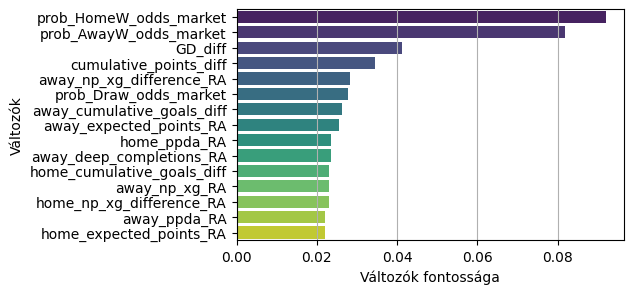

In [38]:
target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

serie_a_tuned_away, serie_a_params_away, serie_a_top_features_away = random_forest_tuning(serie_a,
                                                                                          target_col,
                                                                                          drop)

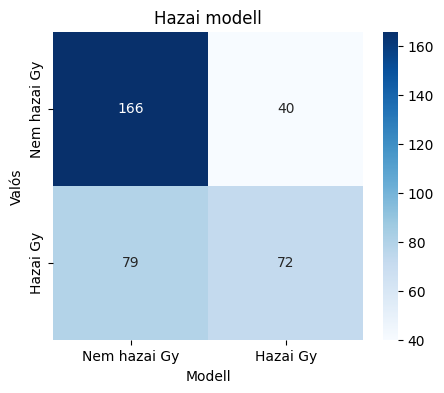

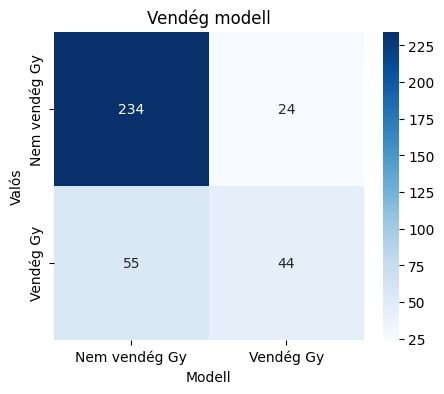

legjobb threshold #1: 0.16
legjobb threshold #2: 0.48


In [110]:
# drop_cols_home =['target_away_win', 'target_draw','target_o2.5']

drop_cols_home =['target_away_win', 'target_draw','target_o2.5',
                 'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# drop_cols_away =['target_home_win', 'target_draw','target_o2.5']

drop_cols_away =['target_home_win', 'target_draw','target_o2.5',
                'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']


test_predictions_serie_a, random_forest_home_serie_a, random_forest_away_serie_a = random_forest_final(
    serie_a,
    drop_cols_home,
    drop_cols_away,
    serie_a_params_home,
    serie_a_params_away
)

In [111]:
pred_odds_serie_a = process_predictions(test_predictions_serie_a)

Summary for HARD VOTING model


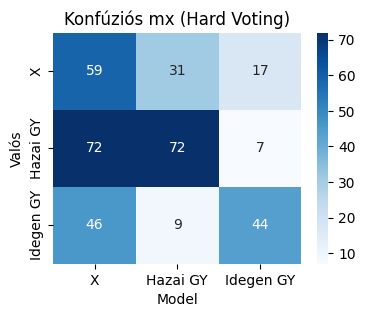


Classification Report (Hard Voting):
               precision    recall  f1-score   support

           0     0.3333    0.5514    0.4155       107
           1     0.6429    0.4768    0.5475       151
           2     0.6471    0.4444    0.5269        99

    accuracy                         0.4902       357
   macro avg     0.5411    0.4909    0.4967       357
weighted avg     0.5513    0.4902    0.5022       357


Summary for SOFT VOTING model


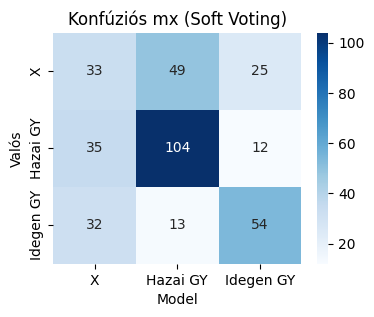


Classification Report (Soft Voting):
               precision    recall  f1-score   support

           0     0.3300    0.3084    0.3188       107
           1     0.6265    0.6887    0.6562       151
           2     0.5934    0.5455    0.5684        99

    accuracy                         0.5350       357
   macro avg     0.5166    0.5142    0.5145       357
weighted avg     0.5285    0.5350    0.5307       357



In [112]:
evaluation(pred_odds_serie_a)

In [113]:
roi_hard,roi_soft, df_profit_hard, df_loss_hard,df_profit_soft,df_loss_soft,pred_odds_soft = betting_randomforest(pred_odds_serie_a,
                                                                                                                  stake=500)

ROI hard : 6.87%
ROI soft : 7.40%


In [63]:
# ROI_sim_per_round(pred_odds_soft, round_size=10)

## Ligue 1, full time result

tanító halmaz dimenziók: (2817, 67)
validációs halmaz dimenziók: (352, 67)

tanító halmaz indexek: (i: 1 -> 2817)
validációs halmaz:  (i: 2818 -> 3169)

legjobb modell hiperparameterei: OrderedDict({'criterion': 'entropy', 'max_depth': 17, 'max_features': 'sqrt', 'min_samples_leaf': 15, 'min_samples_split': 8, 'n_estimators': 1000})
accuracy: 0.6847

összegzés:
              precision    recall  f1-score   support

           0       0.72      0.75      0.73       205
           1       0.63      0.60      0.61       147

    accuracy                           0.68       352
   macro avg       0.68      0.67      0.67       352
weighted avg       0.68      0.68      0.68       352



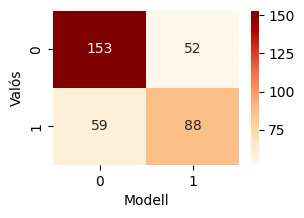


top15 valtozo:
                       feature  importance
53      prob_HomeW_odds_market    0.092823
54      prob_AwayW_odds_market    0.081728
52                     GD_diff    0.042685
51      cumulative_points_diff    0.037821
55       prob_Draw_odds_market    0.034630
31    away_np_xg_difference_RA    0.030880
7                   home_xg_RA    0.027432
8                home_np_xg_RA    0.027270
35  away_cumulative_goals_diff    0.026192
9     home_np_xg_difference_RA    0.026106
28     away_expected_points_RA    0.025812
57       prob_O2.5_odds_market    0.025395
6      home_expected_points_RA    0.024932
10                home_ppda_RA    0.024490
13  home_cumulative_goals_diff    0.023867


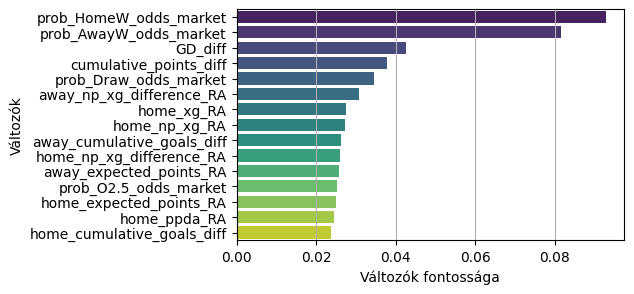

In [116]:
target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

ligue_1_tuned_home, ligue_1_params_home, ligue_1_top_features_home = random_forest_tuning(
    ligue_1,
    target_col,
    drop
)


tanító halmaz dimenziók: (2817, 67)
validációs halmaz dimenziók: (352, 67)

tanító halmaz indexek: (i: 1 -> 2817)
validációs halmaz:  (i: 2818 -> 3169)

legjobb modell hiperparameterei: OrderedDict({'criterion': 'gini', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 100})
accuracy: 0.6818

összegzés:
              precision    recall  f1-score   support

           0       0.70      0.90      0.79       233
           1       0.56      0.26      0.36       119

    accuracy                           0.68       352
   macro avg       0.63      0.58      0.57       352
weighted avg       0.66      0.68      0.64       352



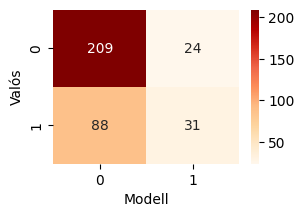


top15 valtozo:
                       feature  importance
53      prob_HomeW_odds_market    0.063533
54      prob_AwayW_odds_market    0.063009
52                     GD_diff    0.035263
51      cumulative_points_diff    0.031510
35  away_cumulative_goals_diff    0.028877
28     away_expected_points_RA    0.028612
9     home_np_xg_difference_RA    0.027810
31    away_np_xg_difference_RA    0.027541
10                home_ppda_RA    0.027094
55       prob_Draw_odds_market    0.026786
8                home_np_xg_RA    0.024896
32                away_ppda_RA    0.024523
44            home_clinicality    0.024374
11    home_deep_completions_RA    0.023282
29                  away_xg_RA    0.023265


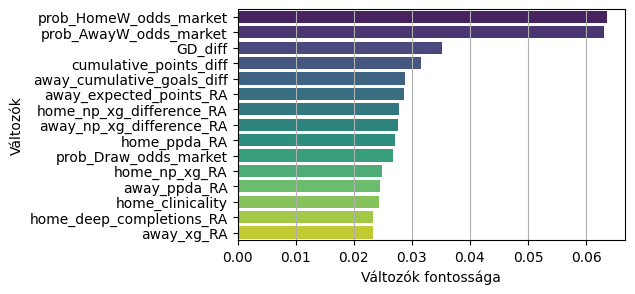

In [117]:
target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

ligue_1_tuned_away, ligue_1_params_away, ligue_1_top_features_away = random_forest_tuning(
    ligue_1,
    target_col,
    drop
)


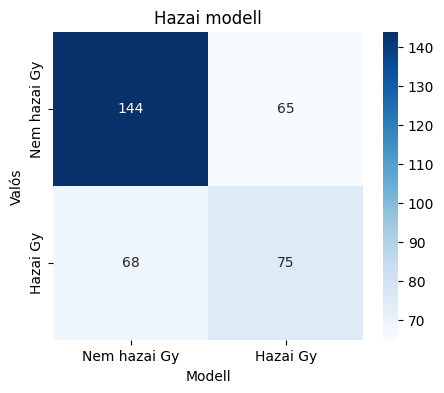

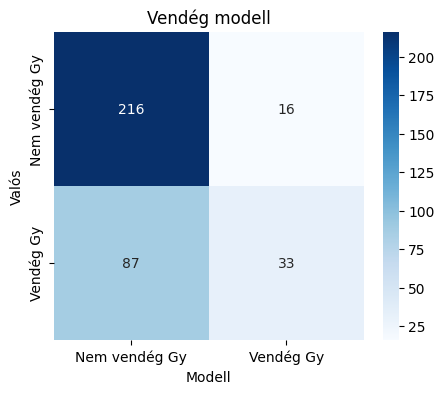

legjobb threshold #1: 0.15
legjobb threshold #2: 0.48


In [125]:
# drop_cols_home =['target_away_win', 'target_draw','target_o2.5']

drop_cols_home =['target_away_win', 'target_draw','target_o2.5',
                 'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# drop_cols_away =['target_home_win', 'target_draw','target_o2.5']

drop_cols_away =['target_home_win', 'target_draw','target_o2.5',
                'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']


test_predictions_ligue_1, random_forest_home_ligue_1, random_forest_away_ligue_1 = random_forest_final(
    ligue_1,
    drop_cols_home,
    drop_cols_away,
    ligue_1_params_home,
    ligue_1_params_away
)

In [126]:
pred_odds_ligue1 = process_predictions(test_predictions_ligue_1)

Summary for HARD VOTING model


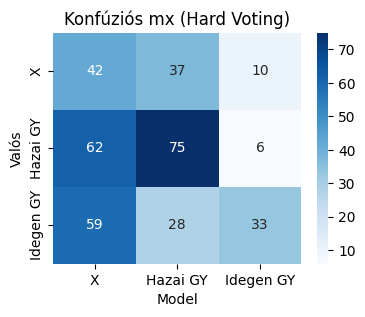


Classification Report (Hard Voting):
               precision    recall  f1-score   support

           0     0.2577    0.4719    0.3333        89
           1     0.5357    0.5245    0.5300       143
           2     0.6735    0.2750    0.3905       120

    accuracy                         0.4261       352
   macro avg     0.4890    0.4238    0.4180       352
weighted avg     0.5124    0.4261    0.4327       352


Summary for SOFT VOTING model


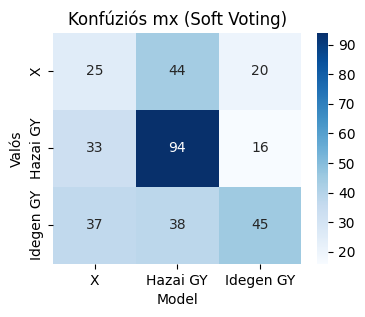


Classification Report (Soft Voting):
               precision    recall  f1-score   support

           0     0.2632    0.2809    0.2717        89
           1     0.5341    0.6573    0.5893       143
           2     0.5556    0.3750    0.4478       120

    accuracy                         0.4659       352
   macro avg     0.4509    0.4377    0.4363       352
weighted avg     0.4729    0.4659    0.4608       352



In [127]:
evaluation(pred_odds_ligue1)

In [128]:
roi_hard,roi_soft, df_profit_hard, df_loss_hard,df_profit_soft,df_loss_soft,pred_odds_soft = betting_randomforest(pred_odds_ligue1,
                                                                                                                  stake=500)

ROI hard : -7.54%
ROI soft : -6.77%


In [70]:
# ROI_sim_per_round(pred_odds_soft, round_size=10)

## La Liga, full time result

tanító halmaz dimenziók: (2958, 67)
validációs halmaz dimenziók: (370, 67)

tanító halmaz indexek: (i: 1 -> 2958)
validációs halmaz:  (i: 2959 -> 3328)

legjobb modell hiperparameterei: OrderedDict({'criterion': 'gini', 'max_depth': 41, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 15, 'n_estimators': 1000})
accuracy: 0.6189

összegzés:
              precision    recall  f1-score   support

           0       0.61      0.74      0.67       191
           1       0.64      0.49      0.56       179

    accuracy                           0.62       370
   macro avg       0.62      0.61      0.61       370
weighted avg       0.62      0.62      0.61       370



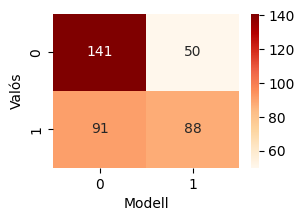


top15 valtozo:
                       feature  importance
53      prob_HomeW_odds_market    0.136619
54      prob_AwayW_odds_market    0.126132
52                     GD_diff    0.055959
51      cumulative_points_diff    0.045347
55       prob_Draw_odds_market    0.044259
35  away_cumulative_goals_diff    0.029847
13  home_cumulative_goals_diff    0.029148
6      home_expected_points_RA    0.023933
31    away_np_xg_difference_RA    0.023820
9     home_np_xg_difference_RA    0.023518
28     away_expected_points_RA    0.022312
33    away_deep_completions_RA    0.022051
30               away_np_xg_RA    0.021302
11    home_deep_completions_RA    0.020444
8                home_np_xg_RA    0.020134


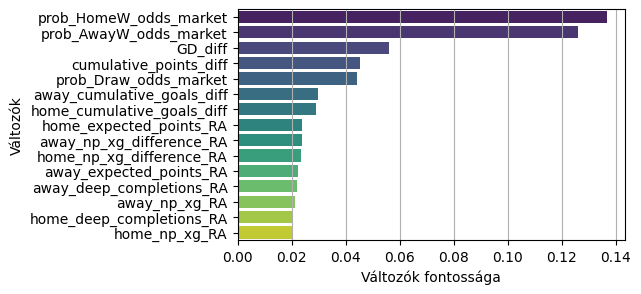

In [129]:
target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

la_liga_tuned_home, la_liga_params_home, la_liga_top_features_home = random_forest_tuning(
    la_liga,
    target_col,
    drop
)

tanító halmaz dimenziók: (2958, 67)
validációs halmaz dimenziók: (370, 67)

tanító halmaz indexek: (i: 1 -> 2958)
validációs halmaz:  (i: 2959 -> 3328)

legjobb modell hiperparameterei: OrderedDict({'criterion': 'gini', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100})
accuracy: 0.7351

összegzés:
              precision    recall  f1-score   support

           0       0.76      0.93      0.83       265
           1       0.58      0.25      0.35       105

    accuracy                           0.74       370
   macro avg       0.67      0.59      0.59       370
weighted avg       0.71      0.74      0.70       370



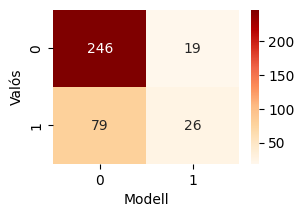


top15 valtozo:
                       feature  importance
53      prob_HomeW_odds_market    0.056170
54      prob_AwayW_odds_market    0.053291
52                     GD_diff    0.036441
51      cumulative_points_diff    0.027952
55       prob_Draw_odds_market    0.027427
30               away_np_xg_RA    0.026474
35  away_cumulative_goals_diff    0.025742
29                  away_xg_RA    0.025714
31    away_np_xg_difference_RA    0.024764
28     away_expected_points_RA    0.024301
33    away_deep_completions_RA    0.023977
9     home_np_xg_difference_RA    0.023937
32                away_ppda_RA    0.023852
10                home_ppda_RA    0.023312
6      home_expected_points_RA    0.023211


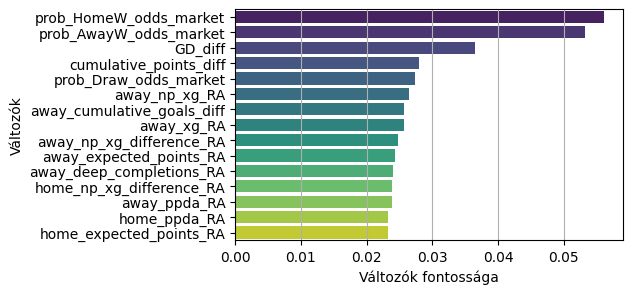

In [130]:
target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

la_liga_tuned_away, la_liga_params_away, la_liga_top_features_away = random_forest_tuning(
    la_liga,
    target_col,
    drop
)


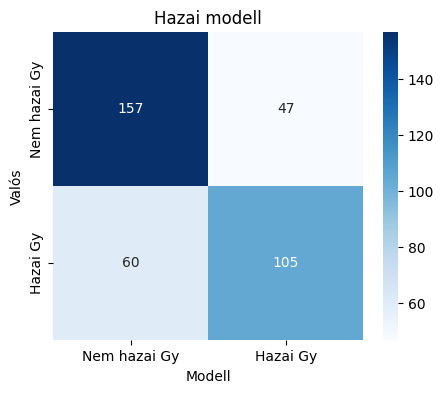

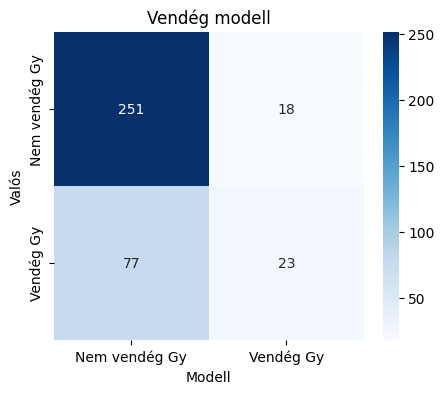

legjobb threshold #1: 0.19
legjobb threshold #2: 0.52


In [131]:
# drop_cols_home =['target_away_win', 'target_draw','target_o2.5']

drop_cols_home =['target_away_win', 'target_draw','target_o2.5',
                 'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# drop_cols_away =['target_home_win', 'target_draw','target_o2.5']

drop_cols_away =['target_home_win', 'target_draw','target_o2.5',
                'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']


test_predictions_la_liga, random_forest_home_la_liga, random_forest_away_la_liga = random_forest_final(
    la_liga,
    drop_cols_home,
    drop_cols_away,
    la_liga_params_home,
    la_liga_params_away
)

In [132]:
pred_odds_laliga = process_predictions(test_predictions_la_liga)

Summary for HARD VOTING model


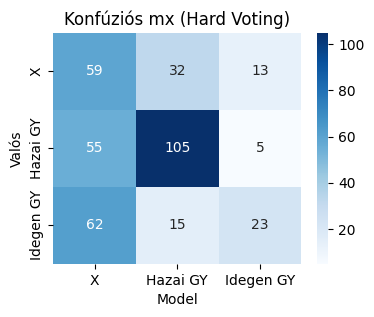


Classification Report (Hard Voting):
               precision    recall  f1-score   support

           0     0.3352    0.5673    0.4214       104
           1     0.6908    0.6364    0.6625       165
           2     0.5610    0.2300    0.3262       100

    accuracy                         0.5068       369
   macro avg     0.5290    0.4779    0.4700       369
weighted avg     0.5554    0.5068    0.5034       369


Summary for SOFT VOTING model


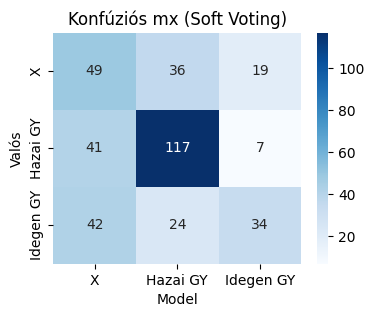


Classification Report (Soft Voting):
               precision    recall  f1-score   support

           0     0.3712    0.4712    0.4153       104
           1     0.6610    0.7091    0.6842       165
           2     0.5667    0.3400    0.4250       100

    accuracy                         0.5420       369
   macro avg     0.5330    0.5067    0.5082       369
weighted avg     0.5538    0.5420    0.5382       369



In [133]:
evaluation(pred_odds_laliga)

In [134]:
roi_hard,roi_soft, df_profit_hard, df_loss_hard,df_profit_soft,df_loss_soft,pred_odds_soft = betting_randomforest(pred_odds_laliga,
                                                                                                                  stake=500)

ROI hard : 9.75%
ROI soft : 13.70%


In [138]:
# ROI_sim_per_round(pred_odds_soft, round_size=10)

## big5 combined, full time result

tanító halmaz dimenziók: (13971, 67)
validációs halmaz dimenziók: (1746, 67)

tanító halmaz indexek: (i: 1 -> 13971)
validációs halmaz:  (i: 13972 -> 15717)

legjobb modell hiperparameterei: OrderedDict({'criterion': 'entropy', 'max_depth': 27, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 13, 'n_estimators': 108})
accuracy: 0.6546

összegzés:
              precision    recall  f1-score   support

           0       0.65      0.78      0.71       949
           1       0.66      0.51      0.57       797

    accuracy                           0.65      1746
   macro avg       0.66      0.64      0.64      1746
weighted avg       0.66      0.65      0.65      1746



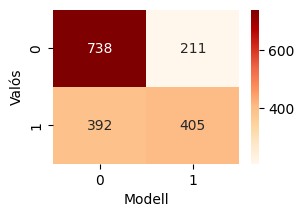


top15 valtozo:
                     feature  importance
53    prob_HomeW_odds_market    0.065770
54    prob_AwayW_odds_market    0.065604
52                   GD_diff    0.036584
55     prob_Draw_odds_market    0.034712
51    cumulative_points_diff    0.031423
6    home_expected_points_RA    0.028292
31  away_np_xg_difference_RA    0.027722
9   home_np_xg_difference_RA    0.025971
28   away_expected_points_RA    0.025067
29                away_xg_RA    0.024881
30             away_np_xg_RA    0.024822
10              home_ppda_RA    0.024478
8              home_np_xg_RA    0.024315
7                 home_xg_RA    0.024099
32              away_ppda_RA    0.023612


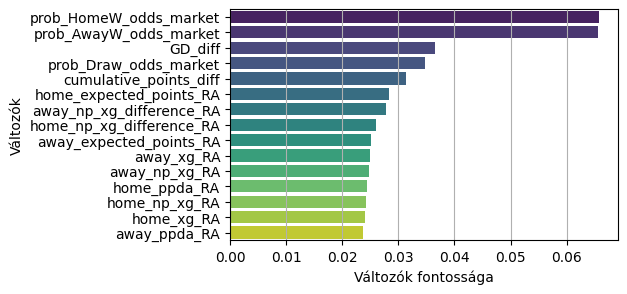

In [47]:
target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']


big5_tuned_home, big5_params_home, big5_top_features_home = random_forest_tuning(
    big5,
    target_col,
    drop
)

tanító halmaz dimenziók: (13971, 67)
validációs halmaz dimenziók: (1746, 67)

tanító halmaz indexek: (i: 1 -> 13971)
validációs halmaz:  (i: 13972 -> 15717)

legjobb modell hiperparameterei: OrderedDict({'criterion': 'entropy', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 7, 'n_estimators': 100})
accuracy: 0.7159

összegzés:
              precision    recall  f1-score   support

           0       0.75      0.90      0.82      1222
           1       0.55      0.28      0.37       524

    accuracy                           0.72      1746
   macro avg       0.65      0.59      0.59      1746
weighted avg       0.69      0.72      0.68      1746



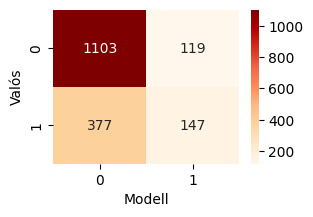


top15 valtozo:
                     feature  importance
53    prob_HomeW_odds_market    0.072567
54    prob_AwayW_odds_market    0.066589
52                   GD_diff    0.033608
55     prob_Draw_odds_market    0.030962
51    cumulative_points_diff    0.030956
31  away_np_xg_difference_RA    0.029206
9   home_np_xg_difference_RA    0.028411
28   away_expected_points_RA    0.028112
30             away_np_xg_RA    0.024776
45          away_clinicality    0.024625
10              home_ppda_RA    0.024624
32              away_ppda_RA    0.024487
6    home_expected_points_RA    0.024398
44          home_clinicality    0.024172
29                away_xg_RA    0.024149


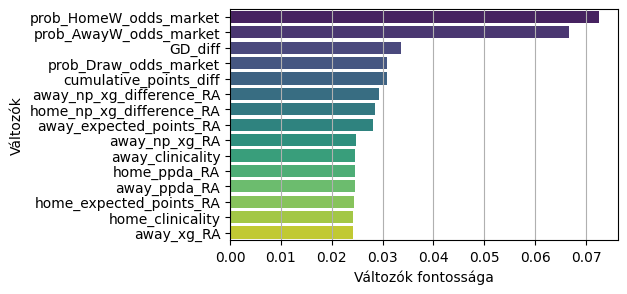

In [48]:
target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

big5_tuned_away, big5_params_away, big5_top_features_away = random_forest_tuning(
    big5,
    target_col,
    drop
)

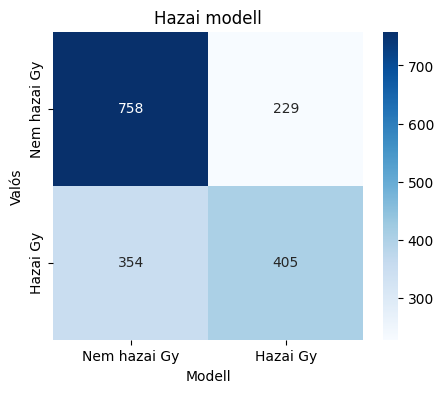

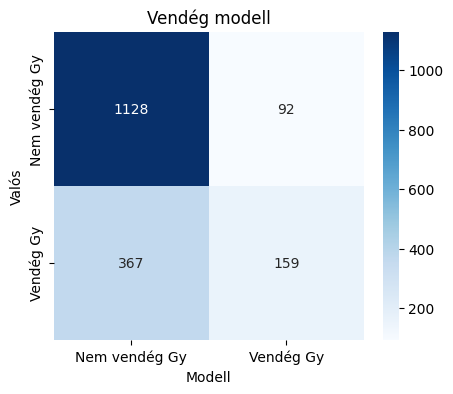

legjobb threshold #1: 0.18
legjobb threshold #2: 0.42


In [49]:
# drop_cols_home =['target_away_win', 'target_draw','target_o2.5']

drop_cols_home =['target_away_win', 'target_draw','target_o2.5',
                 'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# drop_cols_away =['target_home_win', 'target_draw','target_o2.5']

drop_cols_away =['target_home_win', 'target_draw','target_o2.5',
                'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']


test_predictions_big5, random_forest_home_big5, random_forest_away_big5 = random_forest_final(
    big5,
    drop_cols_home,
    drop_cols_away,
    big5_params_home,
    big5_params_away
)

In [50]:
pred_odds_big5 = process_predictions(test_predictions_big5)

Summary for HARD VOTING model


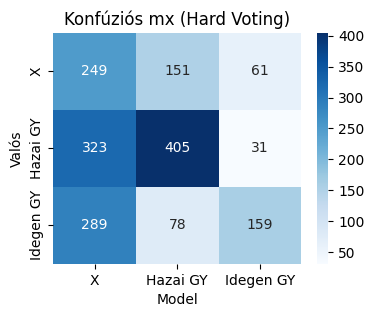


Classification Report (Hard Voting):
               precision    recall  f1-score   support

           0     0.2892    0.5401    0.3767       461
           1     0.6388    0.5336    0.5815       759
           2     0.6335    0.3023    0.4093       526

    accuracy                         0.4656      1746
   macro avg     0.5205    0.4587    0.4558      1746
weighted avg     0.5449    0.4656    0.4755      1746


Summary for SOFT VOTING model


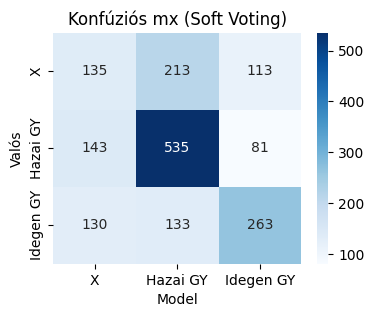


Classification Report (Soft Voting):
               precision    recall  f1-score   support

           0     0.3309    0.2928    0.3107       461
           1     0.6073    0.7049    0.6524       759
           2     0.5755    0.5000    0.5351       526

    accuracy                         0.5344      1746
   macro avg     0.5045    0.4992    0.4994      1746
weighted avg     0.5247    0.5344    0.5269      1746



In [51]:
evaluation(pred_odds_big5)

In [52]:
roi_hard,roi_soft, df_profit_hard, df_loss_hard,df_profit_soft,df_loss_soft,pred_odds_soft = betting_randomforest(pred_odds_big5,
                                                                                                                  stake=500)

ROI hard : -0.05%
ROI soft : 5.16%


In [ ]:
# ROI_sim_per_round(pred_odds_soft, round_size=48)

# Under/Over 2.5 

## PL

In [75]:
def random_forest_tuning_underover(df, target_col, drop_cols=[]):
    
    df = df.dropna().reset_index(drop=True)

    X = df.drop(columns=[target_col] + drop_cols)
    y = df[target_col]

    train_n = int(round(len(df) * 0.8, 0))
    val_n = int(round(len(df) * 0.1, 0))

    train_set = df.iloc[:train_n]        
    val_set = df.iloc[train_n:train_n + val_n] 

    print(f"tanító halmaz dimenziók: {train_set.shape}")
    print(f"validációs halmaz dimenziók: {val_set.shape}")
        
    print(f"\ntanító halmaz indexek: (i: {train_set.index[0]+1} -> {train_set.index[-1]+1})")
    print(f"validációs halmaz:  (i: {val_set.index[0]+1} -> {val_set.index[-1]+1})")

    X_train, y_train = train_set.drop(columns=[target_col] + drop_cols), train_set[target_col]
    X_val, y_val = val_set.drop(columns=[target_col] + drop_cols), val_set[target_col]

    param_space = {
        'n_estimators': Integer(100, 1000),
        'max_depth': Integer(10, 50),
        'min_samples_split': Integer(2, 20),
        'min_samples_leaf': Integer(1, 20),
        'criterion': ['gini', 'entropy'],
        'max_features': ['sqrt', 'log2'],
        'class_weight': ['balanced', None]  
    }
    
    rf = RandomForestClassifier(random_state=1)
    
    bayes_search = BayesSearchCV(
        estimator=rf,
        search_spaces=param_space,
        n_iter=30,  
        scoring='f1',
        refit='f1',
        cv=TimeSeriesSplit(n_splits=5),  
        verbose=0,
        n_jobs=-1,  
        random_state=1
    )

    bayes_search.fit(X_train, y_train)  

    best_model = bayes_search.best_estimator_
    best_params = bayes_search.best_params_
    print("\nlegjobb modell hiperparameterei:", best_params)

    y_val_probs = best_model.predict_proba(X_val)
    val_set = val_set.copy()
    val_set['P_0'] = y_val_probs[:, 0] 
    val_set['P_1'] = y_val_probs[:, 1]  

    thresholds = np.arange(0.1, 0.7, 0.01)
    f1_scores = []
    
    for t in thresholds:
        preds = (y_val_probs[:, 1] >= t).astype(int)
        f1_scores.append(f1_score(y_val, preds, average='macro'))
    
    best_threshold = thresholds[np.argmax(f1_scores)]
    best_f1 = max(f1_scores)
    
    print(f"\n legjobb threshold: {best_threshold:.2f}, legjobb F1: {best_f1:.4f}")
    
    plt.figure(figsize=(7, 4))
    plt.plot(thresholds, f1_scores, color='teal')
    plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best: {best_threshold:.2f}')
    plt.xlabel("Határérték")
    plt.ylabel("Átlagos F1-érték")
    plt.grid()
    plt.show()

    y_pred = (y_val_probs[:, 1] >= best_threshold).astype(int)
    val_set['Predicted'] = y_pred

    accuracy = accuracy_score(y_val, y_pred)
    print(f"accuracy: {accuracy:.4f}")
    print(classification_report(y_val, y_pred))

    plt.figure(figsize=(3, 2))
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="OrRd", xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel("Modell")
    plt.ylabel("Valós")
    plt.show()

    feature_importances = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model.feature_importances_
    }).sort_values(by='importance', ascending=False)
    
    print("\ntop15 valtozo:")
    top_features = feature_importances.head(15)
    print(top_features)
    
    plt.figure(figsize=(5, 3))
    sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')
    plt.xlabel("Változók fontossága")
    plt.ylabel("Változók")
    plt.grid(axis='x')
    plt.show()

    return val_set, best_params, top_features

tanító halmaz dimenziók: (2958, 67)
validációs halmaz dimenziók: (370, 67)

tanító halmaz indexek: (i: 1 -> 2958)
validációs halmaz:  (i: 2959 -> 3328)

legjobb modell hiperparameterei: OrderedDict({'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 16, 'min_samples_split': 20, 'n_estimators': 1000})

 legjobb threshold: 0.56, legjobb F1: 0.5584


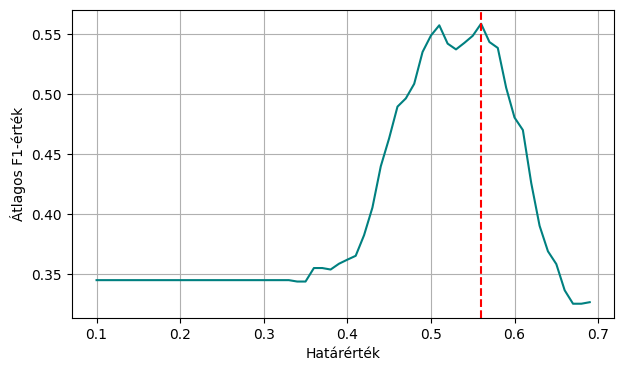

accuracy: 0.5622
              precision    recall  f1-score   support

           0       0.53      0.69      0.60       175
           1       0.62      0.45      0.52       195

    accuracy                           0.56       370
   macro avg       0.57      0.57      0.56       370
weighted avg       0.58      0.56      0.56       370



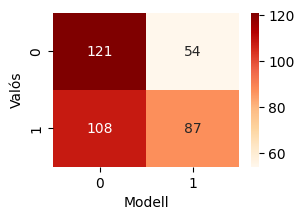


top15 valtozo:
                     feature  importance
57     prob_O2.5_odds_market    0.046499
56     prob_U2.5_odds_market    0.045717
55     prob_Draw_odds_market    0.038093
32              away_ppda_RA    0.033251
24             away_shots_RA    0.032669
45          away_clinicality    0.030862
33  away_deep_completions_RA    0.029380
44          home_clinicality    0.027241
7                 home_xg_RA    0.026988
53    prob_HomeW_odds_market    0.026952
10              home_ppda_RA    0.026423
6    home_expected_points_RA    0.026149
54    prob_AwayW_odds_market    0.026016
9   home_np_xg_difference_RA    0.025858
29                away_xg_RA    0.025718


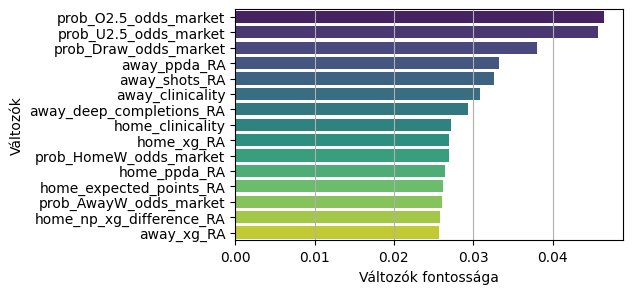

In [76]:
target_col = 'target_o2.5'
drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
#        'prob_HomeW_odds_market','prob_AwayW_odds_market','prob_Draw_odds_market','prob_U2.5_odds_market','prob_O2.5_odds_market']


premier_league_tuning_underover, premier_league_params_underover, premier_league_topfeatures_underover = random_forest_tuning_underover(
    premier_league,
    target_col,
    drop)

In [119]:
def random_forest_test_underover(df, target_col, drop_cols=[], best_params={}):
    
    df = df.dropna().reset_index(drop=True)

    X = df.drop(columns=[target_col] + drop_cols)
    y = df[target_col]
    
    train_n = int(round(len(df) * 0.9, 0))
    test_n = len(df) - train_n 

    train_set = df.iloc[:train_n]        
    test_set = df.iloc[train_n:] 

    print(f"\ntanító halmaz indexek: (i: {train_set.index[0]+1} -> {train_set.index[-1]+1})")
    print(f"teszt halmaz:  (i: {test_set.index[0]+1} -> {test_set.index[-1]+1})")

    X_train, y_train = train_set.drop(columns=[target_col] + drop_cols), train_set[target_col]
    X_test, y_test = test_set.drop(columns=[target_col] + drop_cols), test_set[target_col]
                
    rf = RandomForestClassifier(
        n_estimators=best_params.get('n_estimators', 500),
        max_depth=best_params.get('max_depth', 10),
        min_samples_split=best_params.get('min_samples_split', 2),
        min_samples_leaf=best_params.get('min_samples_leaf', 1),
        criterion=best_params.get('criterion', 'entropy'),
        max_features=best_params.get('max_features', 'sqrt'),
        random_state=best_params.get('random_state', 1),
        # class_weight='balanced'
        class_weight=best_params.get('class_weight', None)
    )
    
    rf.fit(X_train, y_train)

    y_test_probs = rf.predict_proba(X_test)
    
    thresholds = np.arange(0.1, 0.7, 0.01)
    f1_scores = []

    for t in thresholds:
        preds = (y_test_probs[:, 1] >= t).astype(int)
        f1_scores.append(f1_score(y_test, preds, average='macro'))

    best_threshold = thresholds[np.argmax(f1_scores)]
    best_f1 = max(f1_scores)

    print(f"\n legjobb threshold: {best_threshold:.2f}, legjobb F1: {best_f1:.4f}")

    plt.figure(figsize=(7, 4))
    plt.plot(thresholds, f1_scores, color='teal')
    plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best: {best_threshold:.2f}')
    plt.xlabel("Határérték")
    plt.ylabel("Átlagos F1-érték")
    plt.grid()
    plt.show()

    y_pred = (y_test_probs[:, 1] >= best_threshold).astype(int)

    test_set = test_set.copy()
    test_set['P_0'] = y_test_probs[:, 0]
    test_set['P_1'] = y_test_probs[:, 1]
    test_set['Predicted'] = y_pred

    print(classification_report(y_test, y_pred))
    
    plt.figure(figsize=(3, 2))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="OrRd", xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel("Modell")
    plt.ylabel("Valós")
    plt.show()

    return test_set, rf



tanító halmaz indexek: (i: 1 -> 3328)
teszt halmaz:  (i: 3329 -> 3698)

 legjobb threshold: 0.57, legjobb F1: 0.5253


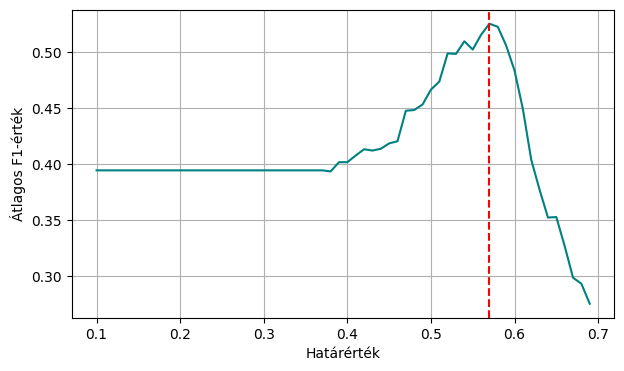

              precision    recall  f1-score   support

           0       0.38      0.44      0.41       129
           1       0.67      0.61      0.64       241

    accuracy                           0.55       370
   macro avg       0.53      0.53      0.53       370
weighted avg       0.57      0.55      0.56       370



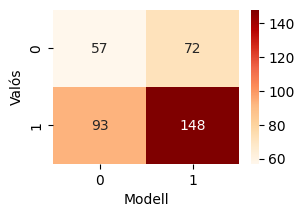

In [120]:
target_col = 'target_o2.5'
drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
        #'prob_HomeW_odds_market','prob_AwayW_odds_market','prob_Draw_odds_market','prob_O2.5_odds_market','prob_O2.5_odds_market']

premier_league_test_underover, pl_rf_uo=random_forest_test_underover(
    premier_league,
    target_col,
    drop,
    premier_league_params_underover)

In [85]:
def betting_RF_underover(df, stake=1):
    
    df = df.copy() 

    df['Profit'] = 0
    df['Profit'] = df.apply(
        lambda row: (stake * row['O2.5_odds_market'] - stake) if row['Predicted'] == 1 and row['target_o2.5'] == 1 else
                     (stake * row['U2.5_odds_market'] - stake) if row['Predicted'] == 0 and row['target_o2.5'] == 0 else
                     -stake, axis=1
    )

    total_profit = df['Profit'].sum()
    total_bets = len(df)

    roi = (total_profit / (total_bets * stake)) * 100
    
    print(f"ROI: {roi:.2f}%")

    df_profit = df[df['target_o2.5'] == df['Predicted']]
    df_loss = df[df['target_o2.5'] != df['Predicted']]

    return roi, df_profit, df_loss, df

roi, df_profit, df_loss, pred_odds = betting_RF_underover(premier_league_test_underover, stake=1)


ROI: -7.22%


>0% profit 17 fordulóban


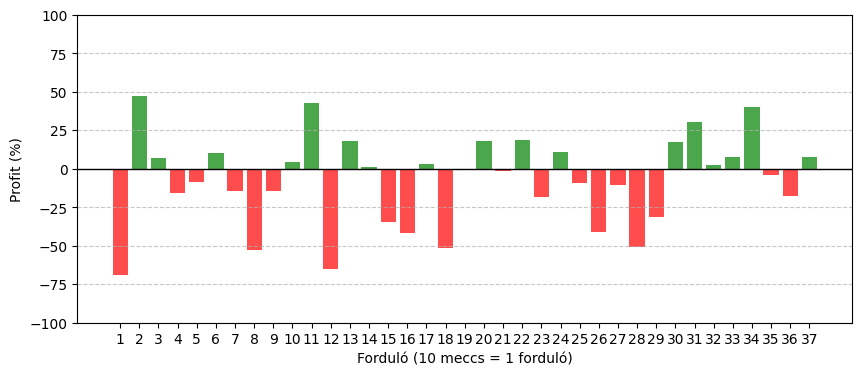

In [86]:
def ROI_sim_UO(df, stake=1, round_size=int):
    
    df = df.copy().reset_index(drop=True)
    
    df['Profit'] = df.apply(
        lambda row: (stake * row['O2.5_odds_market'] - stake) if row['Predicted'] == 1 and row['target_o2.5'] == 1 else
                     (stake * row['U2.5_odds_market'] - stake) if row['Predicted'] == 0 and row['target_o2.5'] == 0 else
                     -stake, axis=1
    )
    
    df['Round'] = (df.index // round_size) + 1  
    roi_per_round = df.groupby('Round').agg({'Profit': 'sum'})
    roi_per_round['Total_Bets'] = df.groupby('Round').size()
    roi_per_round['ROI'] = (roi_per_round['Profit'] / (roi_per_round['Total_Bets'] * stake)) * 100

    positive_rounds = (roi_per_round['ROI'] > 0).sum()
    
    print(f'>0% profit {positive_rounds} fordulóban')

    colors = ['red' if roi < 0 else 'green' for roi in roi_per_round['ROI']]
    plt.figure(figsize=(10, 4))
    plt.bar(roi_per_round.index, roi_per_round['ROI'], color=colors, alpha=0.7)
    plt.xlabel(f'Forduló ({round_size} meccs = 1 forduló)')
    plt.ylabel('Profit (%)')
    plt.axhline(0, color='black', linewidth=1)
    plt.xticks(roi_per_round.index)  
    plt.ylim(-100, 100)  
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig(r'abrak/PL_ROI.jpg', format='jpg', dpi=300)
    plt.show()

ROI_sim_UO(premier_league_test_underover, round_size=10)


## Bundesliga

tanító halmaz dimenziók: (2376, 67)
validációs halmaz dimenziók: (297, 67)

tanító halmaz indexek: (i: 1 -> 2376)
validációs halmaz:  (i: 2377 -> 2673)

legjobb modell hiperparameterei: OrderedDict({'class_weight': None, 'criterion': 'entropy', 'max_depth': 31, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 1000})

 legjobb threshold: 0.53, legjobb F1: 0.5152


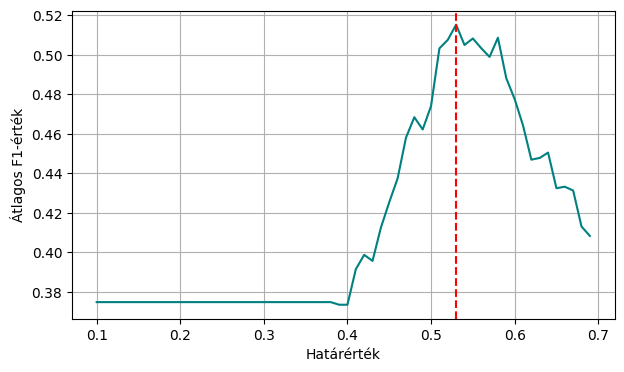

accuracy: 0.5758
              precision    recall  f1-score   support

           0       0.45      0.28      0.34       119
           1       0.62      0.78      0.69       178

    accuracy                           0.58       297
   macro avg       0.53      0.53      0.52       297
weighted avg       0.55      0.58      0.55       297



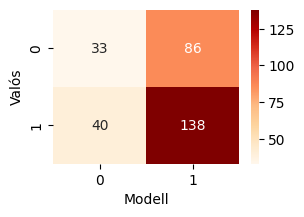


top15 valtozo:
                     feature  importance
56     prob_U2.5_odds_market    0.065247
57     prob_O2.5_odds_market    0.054388
55     prob_Draw_odds_market    0.040438
7                 home_xg_RA    0.032713
44          home_clinicality    0.031289
32              away_ppda_RA    0.030828
10              home_ppda_RA    0.030393
6    home_expected_points_RA    0.030033
8              home_np_xg_RA    0.029164
9   home_np_xg_difference_RA    0.028773
31  away_np_xg_difference_RA    0.028388
11  home_deep_completions_RA    0.027301
54    prob_AwayW_odds_market    0.026420
53    prob_HomeW_odds_market    0.025195
45          away_clinicality    0.023866


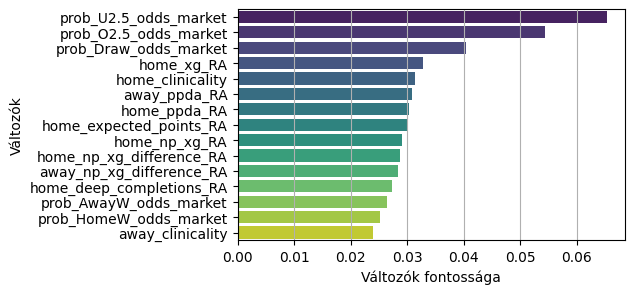

In [89]:
target_col = 'target_o2.5'
drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
#        'prob_HomeW_odds_market','prob_AwayW_odds_market','prob_Draw_odds_market','prob_U2.5_odds_market','prob_O2.5_odds_market']


bundesliga_tuning_underover, bundesliga_params_underover, bundesliga_topfeatures_underover = random_forest_tuning_underover(
    bundesliga,
    target_col,
    drop
)


tanító halmaz indexek: (i: 1 -> 2673)
teszt halmaz:  (i: 2674 -> 2970)

 legjobb threshold: 0.60, legjobb F1: 0.6363


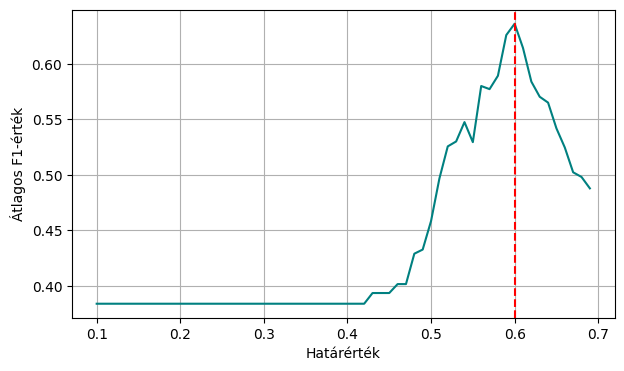

              precision    recall  f1-score   support

           0       0.54      0.58      0.56       112
           1       0.73      0.70      0.71       185

    accuracy                           0.65       297
   macro avg       0.64      0.64      0.64       297
weighted avg       0.66      0.65      0.66       297



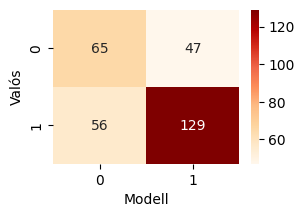

In [121]:
target_col = 'target_o2.5'
drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
        #'prob_HomeW_odds_market','prob_AwayW_odds_market','prob_Draw_odds_market','prob_O2.5_odds_market','prob_O2.5_odds_market']

bundesliga_test_underover, bl_rf_uo = random_forest_test_underover(
    bundesliga,
    target_col,
    drop,
    bundesliga_params_underover
)

In [93]:
roi_bundesliga, df_profit_bundesliga, df_loss_bundesliga, pred_odds_bundesliga = betting_RF_underover(
    bundesliga_test_underover, stake=1
)

ROI: 9.50%


>0% profit 18 fordulóban


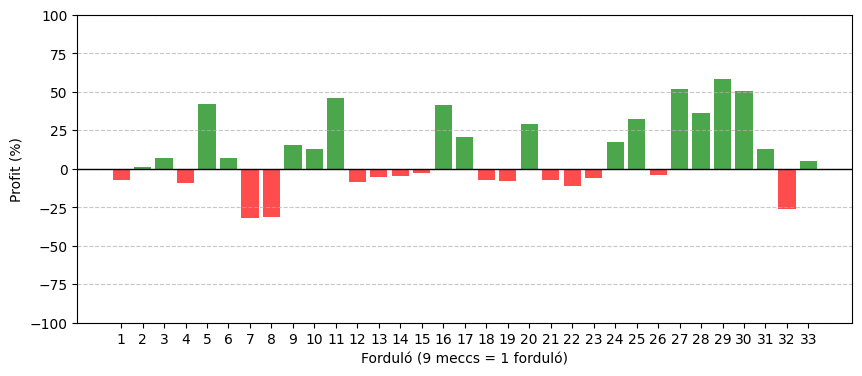

In [94]:
roi_sim_UO_bundesliga = ROI_sim_UO(bundesliga_test_underover, round_size=9)

## serie A

tanító halmaz dimenziók: (2862, 67)
validációs halmaz dimenziók: (358, 67)

tanító halmaz indexek: (i: 1 -> 2862)
validációs halmaz:  (i: 2863 -> 3220)

legjobb modell hiperparameterei: OrderedDict({'class_weight': None, 'criterion': 'entropy', 'max_depth': 49, 'max_features': 'log2', 'min_samples_leaf': 18, 'min_samples_split': 2, 'n_estimators': 185})

 legjobb threshold: 0.52, legjobb F1: 0.5585


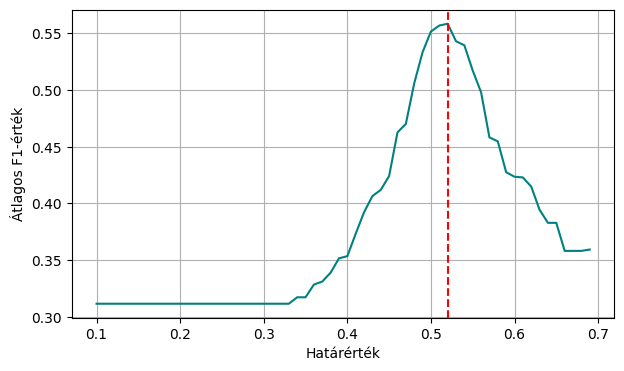

accuracy: 0.5754
              precision    recall  f1-score   support

           0       0.59      0.70      0.64       196
           1       0.54      0.42      0.47       162

    accuracy                           0.58       358
   macro avg       0.57      0.56      0.56       358
weighted avg       0.57      0.58      0.57       358



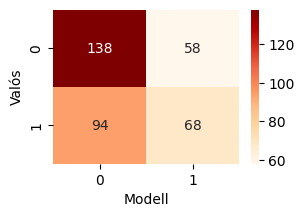


top15 valtozo:
                     feature  importance
56     prob_U2.5_odds_market    0.047573
57     prob_O2.5_odds_market    0.045548
55     prob_Draw_odds_market    0.036458
44          home_clinicality    0.033367
7                 home_xg_RA    0.032279
31  away_np_xg_difference_RA    0.031323
53    prob_HomeW_odds_market    0.029313
32              away_ppda_RA    0.028565
8              home_np_xg_RA    0.028365
54    prob_AwayW_odds_market    0.027011
45          away_clinicality    0.026749
29                away_xg_RA    0.026462
2              home_shots_RA    0.025595
28   away_expected_points_RA    0.025491
10              home_ppda_RA    0.024865


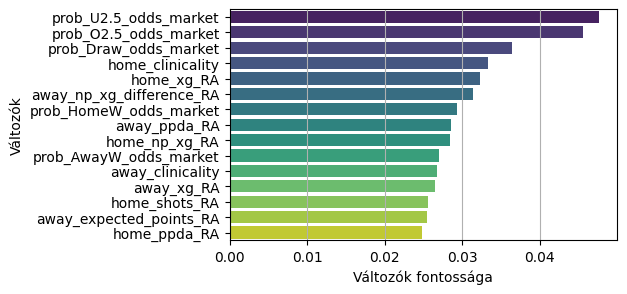

In [95]:
serie_a_tuning_underover, serie_a_params_underover, serie_a_topfeatures_underover = random_forest_tuning_underover(
    serie_a,
    target_col,
    drop
)


tanító halmaz indexek: (i: 1 -> 3220)
teszt halmaz:  (i: 3221 -> 3578)

 legjobb threshold: 0.49, legjobb F1: 0.5724


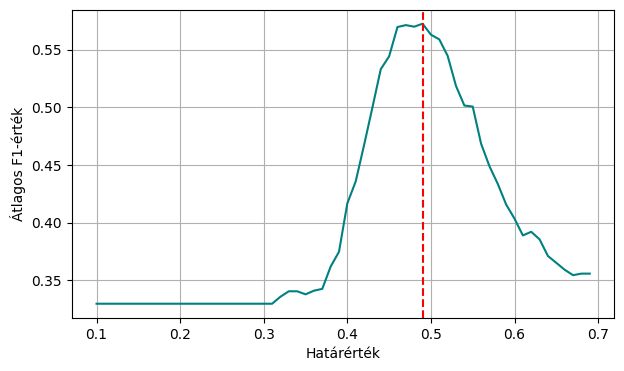

              precision    recall  f1-score   support

           0       0.58      0.59      0.58       182
           1       0.57      0.56      0.56       176

    accuracy                           0.57       358
   macro avg       0.57      0.57      0.57       358
weighted avg       0.57      0.57      0.57       358



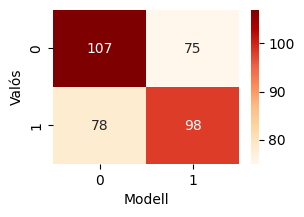

In [122]:
serie_a_test_underover, it_rf_uo = random_forest_test_underover(
    serie_a,
    target_col,
    drop,
    serie_a_params_underover
)

In [97]:
roi_serie_a, df_profit_serie_a, df_loss_serie_a, pred_odds_serie_a = betting_RF_underover(
    serie_a_test_underover, stake=1
)

ROI: -0.09%


>0% profit 17 fordulóban


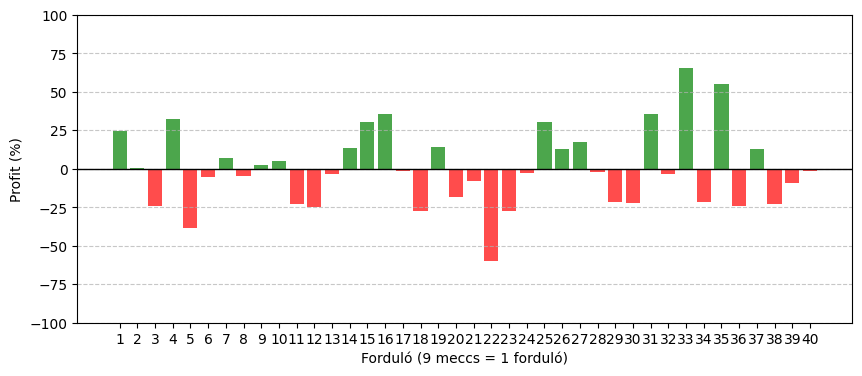

In [98]:
roi_sim_UO_serie_a = ROI_sim_UO(serie_a_test_underover, round_size=9)


## La Liga

tanító halmaz dimenziók: (2958, 67)
validációs halmaz dimenziók: (370, 67)

tanító halmaz indexek: (i: 1 -> 2958)
validációs halmaz:  (i: 2959 -> 3328)

legjobb modell hiperparameterei: OrderedDict({'class_weight': None, 'criterion': 'entropy', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 19, 'n_estimators': 163})

 legjobb threshold: 0.47, legjobb F1: 0.5872


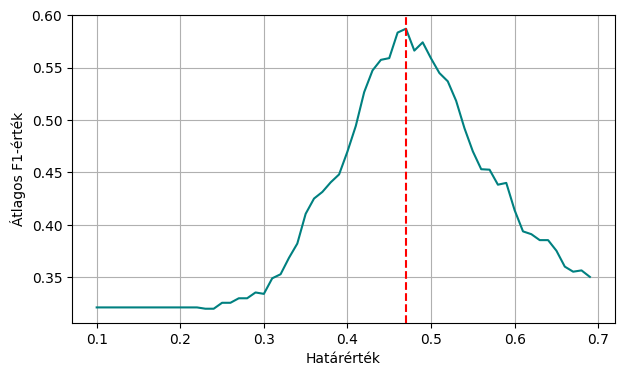

accuracy: 0.5892
              precision    recall  f1-score   support

           0       0.61      0.63      0.62       195
           1       0.57      0.55      0.56       175

    accuracy                           0.59       370
   macro avg       0.59      0.59      0.59       370
weighted avg       0.59      0.59      0.59       370



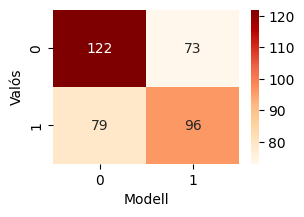


top15 valtozo:
                     feature  importance
56     prob_U2.5_odds_market    0.039139
57     prob_O2.5_odds_market    0.038196
55     prob_Draw_odds_market    0.033699
32              away_ppda_RA    0.030576
10              home_ppda_RA    0.029972
7                 home_xg_RA    0.028391
31  away_np_xg_difference_RA    0.028000
54    prob_AwayW_odds_market    0.027766
28   away_expected_points_RA    0.027663
6    home_expected_points_RA    0.027496
30             away_np_xg_RA    0.027219
29                away_xg_RA    0.026950
9   home_np_xg_difference_RA    0.026499
44          home_clinicality    0.026249
8              home_np_xg_RA    0.026065


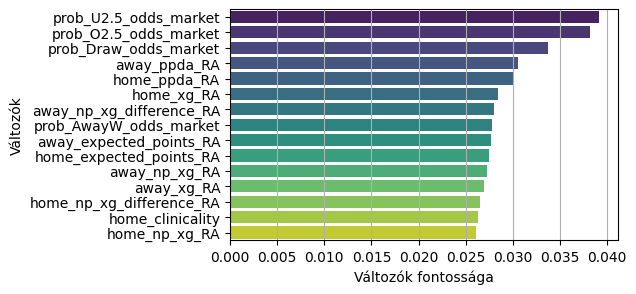

In [99]:
la_liga_tuning_underover, la_liga_params_underover, la_liga_topfeatures_underover = random_forest_tuning_underover(
    la_liga,
    target_col,
    drop
)


tanító halmaz indexek: (i: 1 -> 3327)
teszt halmaz:  (i: 3328 -> 3697)

 legjobb threshold: 0.50, legjobb F1: 0.6041


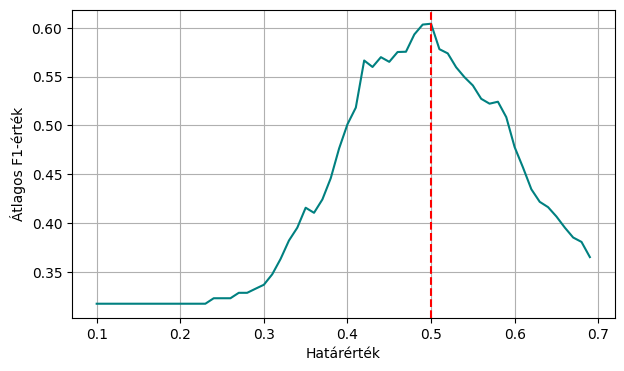

              precision    recall  f1-score   support

           0       0.62      0.72      0.67       198
           1       0.60      0.49      0.54       172

    accuracy                           0.61       370
   macro avg       0.61      0.61      0.60       370
weighted avg       0.61      0.61      0.61       370



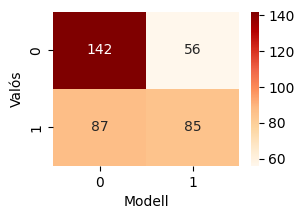

In [123]:
la_liga_test_underover, sp_rf_uo = random_forest_test_underover(
    la_liga,
    target_col,
    drop,
    la_liga_params_underover
)

In [101]:
roi_la_liga, df_profit_la_liga, df_loss_la_liga, pred_odds_la_liga = betting_RF_underover(
    la_liga_test_underover, stake=1
)

ROI: 4.68%


>0% profit 25 fordulóban


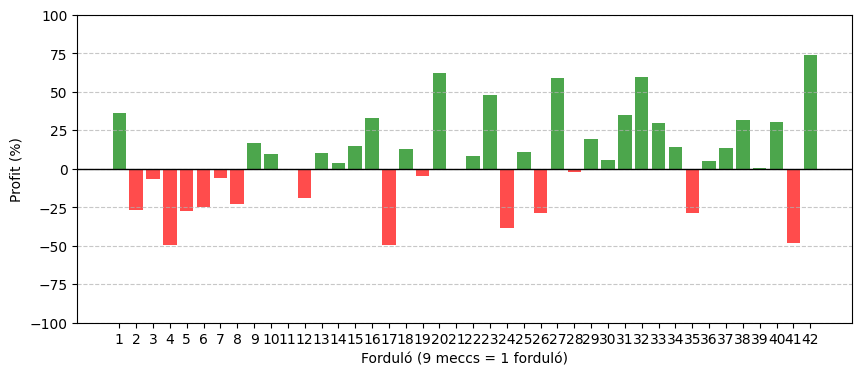

In [102]:
roi_sim_UO_la_liga = ROI_sim_UO(la_liga_test_underover, round_size=9)

## Ligue 1

tanító halmaz dimenziók: (2817, 67)
validációs halmaz dimenziók: (352, 67)

tanító halmaz indexek: (i: 1 -> 2817)
validációs halmaz:  (i: 2818 -> 3169)

legjobb modell hiperparameterei: OrderedDict({'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 17, 'min_samples_split': 2, 'n_estimators': 1000})

 legjobb threshold: 0.59, legjobb F1: 0.5767


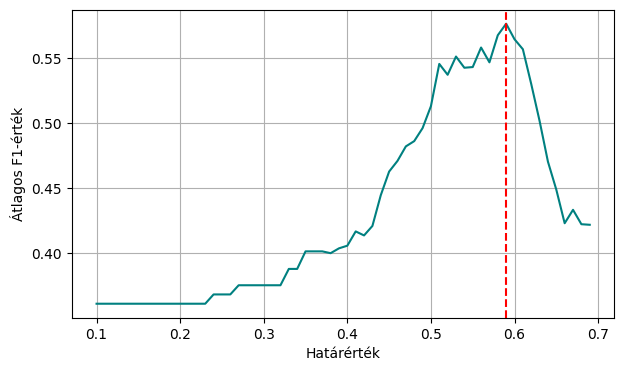

accuracy: 0.5767
              precision    recall  f1-score   support

           0       0.51      0.66      0.58       153
           1       0.66      0.51      0.58       199

    accuracy                           0.58       352
   macro avg       0.59      0.59      0.58       352
weighted avg       0.60      0.58      0.58       352



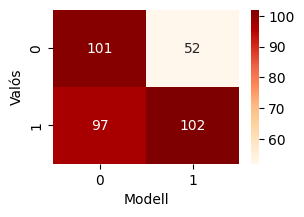


top15 valtozo:
                     feature  importance
57     prob_O2.5_odds_market    0.055112
56     prob_U2.5_odds_market    0.053073
55     prob_Draw_odds_market    0.045019
7                 home_xg_RA    0.033505
8              home_np_xg_RA    0.031036
9   home_np_xg_difference_RA    0.030152
53    prob_HomeW_odds_market    0.029960
54    prob_AwayW_odds_market    0.029572
10              home_ppda_RA    0.029362
30             away_np_xg_RA    0.026780
6    home_expected_points_RA    0.026441
11  home_deep_completions_RA    0.026151
29                away_xg_RA    0.025961
32              away_ppda_RA    0.025837
44          home_clinicality    0.025759


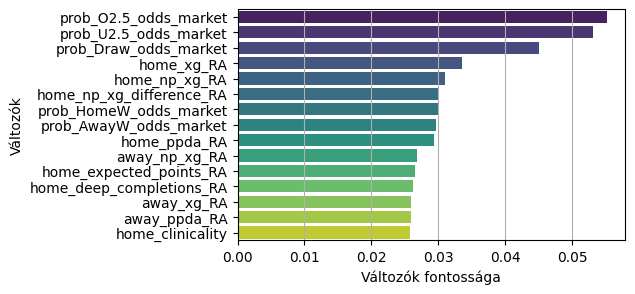

In [103]:
ligue_1_tuning_underover, ligue_1_params_underover, ligue_1_topfeatures_underover = random_forest_tuning_underover(
    ligue_1,
    target_col,
    drop
)


tanító halmaz indexek: (i: 1 -> 3169)
teszt halmaz:  (i: 3170 -> 3521)

 legjobb threshold: 0.58, legjobb F1: 0.5657


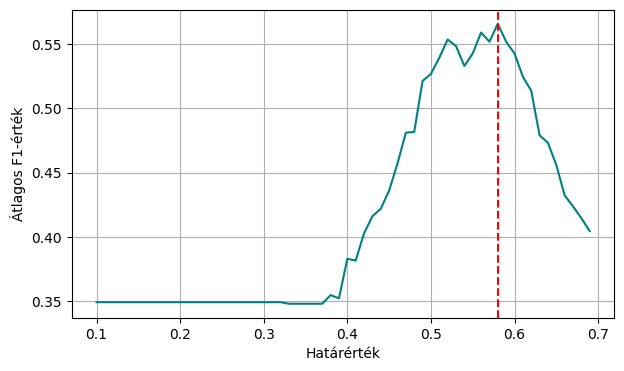

              precision    recall  f1-score   support

           0       0.53      0.74      0.61       163
           1       0.65      0.43      0.52       189

    accuracy                           0.57       352
   macro avg       0.59      0.58      0.57       352
weighted avg       0.59      0.57      0.56       352



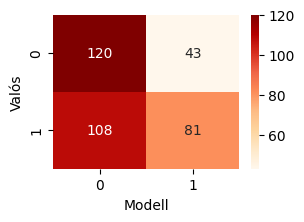

In [124]:
ligue_1_test_underover, fr_rf_uo = random_forest_test_underover(
    ligue_1,
    target_col,
    drop,
    ligue_1_params_underover
)

In [105]:
roi_ligue_1, df_profit_ligue_1, df_loss_ligue_1, pred_odds_ligue_1 = betting_RF_underover(
    ligue_1_test_underover, stake=1
)

ROI: 1.01%


>0% profit 20 fordulóban


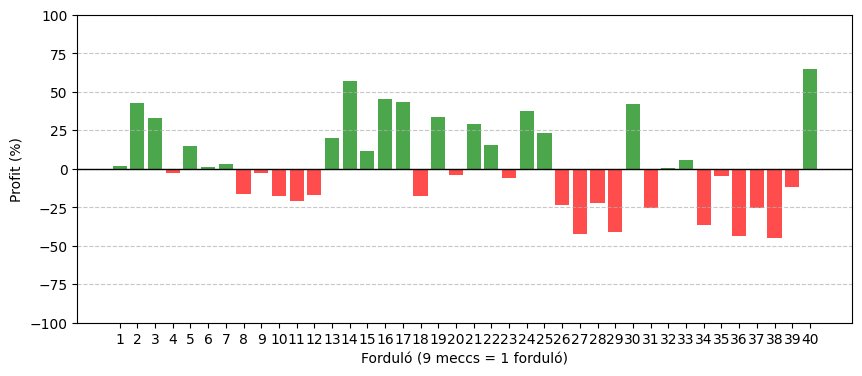

In [106]:
roi_sim_UO_ligue_1 = ROI_sim_UO(ligue_1_test_underover, round_size=9)

## Kombinált

tanító halmaz dimenziók: (13971, 67)
validációs halmaz dimenziók: (1746, 67)

tanító halmaz indexek: (i: 1 -> 13971)
validációs halmaz:  (i: 13972 -> 15717)

legjobb modell hiperparameterei: OrderedDict({'class_weight': None, 'criterion': 'entropy', 'max_depth': 29, 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 16, 'n_estimators': 477})

 legjobb threshold: 0.52, legjobb F1: 0.5718


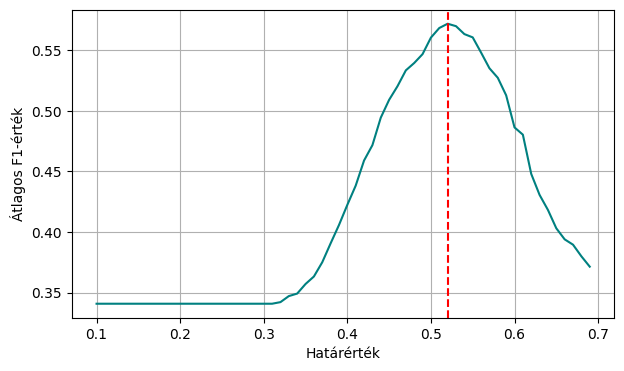

accuracy: 0.5739
              precision    recall  f1-score   support

           0       0.56      0.52      0.54       843
           1       0.58      0.62      0.60       903

    accuracy                           0.57      1746
   macro avg       0.57      0.57      0.57      1746
weighted avg       0.57      0.57      0.57      1746



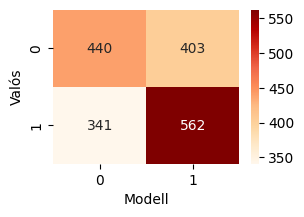


top15 valtozo:
                     feature  importance
56     prob_U2.5_odds_market    0.060304
57     prob_O2.5_odds_market    0.058295
55     prob_Draw_odds_market    0.044333
7                 home_xg_RA    0.030309
53    prob_HomeW_odds_market    0.029093
54    prob_AwayW_odds_market    0.028833
8              home_np_xg_RA    0.028367
6    home_expected_points_RA    0.027579
10              home_ppda_RA    0.026714
32              away_ppda_RA    0.026620
30             away_np_xg_RA    0.026575
9   home_np_xg_difference_RA    0.026434
29                away_xg_RA    0.026327
28   away_expected_points_RA    0.025936
31  away_np_xg_difference_RA    0.025791


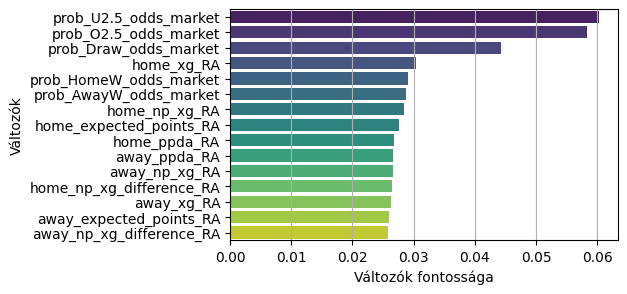

In [107]:
big5_tuning_underover, big5_params_underover, big5_topfeatures_underover = random_forest_tuning_underover(
    big5,
    target_col,
    drop
)


tanító halmaz indexek: (i: 1 -> 15718)
teszt halmaz:  (i: 15719 -> 17464)

 legjobb threshold: 0.54, legjobb F1: 0.6006


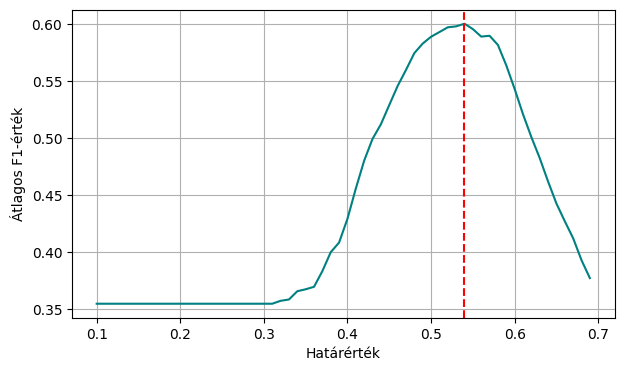

              precision    recall  f1-score   support

           0       0.56      0.57      0.57       786
           1       0.64      0.63      0.64       960

    accuracy                           0.60      1746
   macro avg       0.60      0.60      0.60      1746
weighted avg       0.60      0.60      0.60      1746



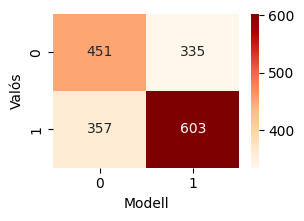

In [108]:
big5_test_underover = random_forest_test_underover(
    big5,
    target_col,
    drop,
    big5_params_underover
)


In [109]:
roi_big5, df_profit_big5, df_loss_big5, pred_odds_big5 = betting_RF_underover(
    big5_test_underover, stake=1
)


ROI: 0.05%


>0% profit 19 fordulóban


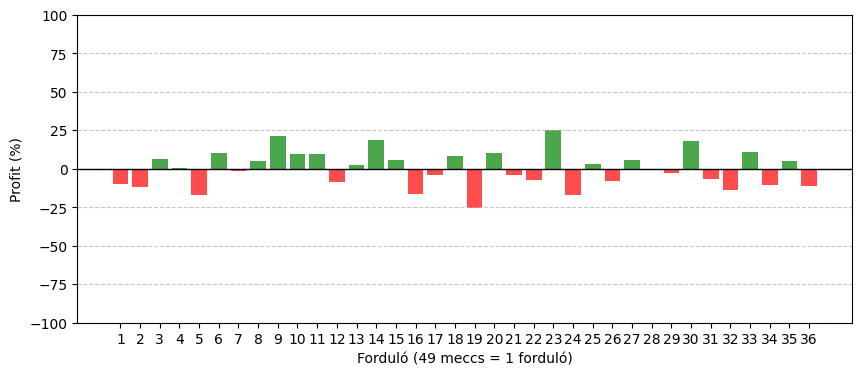

In [111]:
roi_sim_UO_big5 = ROI_sim_UO(big5_test_underover, round_size=49)

# összehasonlítás

## PL

In [194]:
# def generalization_underover(model, df_dict, target_col, drop_cols=[]):

#     results = {}

#     for league_name, df in df_dict.items():
#         print(f"\n=== {league_name} ===")

#         df = df.dropna().reset_index(drop=True)
#         X = df.drop(columns=[target_col] + drop_cols)
#         y = df[target_col]

#         probs = model.predict_proba(X)
#         thresholds = np.arange(0.1, 0.7, 0.01)
#         f1_scores = []

#         for t in thresholds:
#             preds = (probs[:, 1] >= t).astype(int)
#             f1_scores.append(f1_score(y, preds, average='macro'))

#         best_threshold = thresholds[np.argmax(f1_scores)]
#         best_f1 = max(f1_scores)

#         preds = (probs[:, 1] >= best_threshold).astype(int)

#         print(f"legjobb határérték: {best_threshold:.2f} | legjobb f1: {best_f1:.4f}")
#         print(classification_report(y, preds))

#         plt.figure(figsize=(4, 3))
#         cm = confusion_matrix(y, preds)
#         sns.heatmap(cm, annot=True, fmt="d", cmap="OrRd", xticklabels=['0', '1'], yticklabels=['0', '1'])
#         plt.xlabel("Modell")
#         plt.ylabel("Valós")
#         plt.tight_layout()
#         plt.show()

#         df_result = df.copy()
#         df_result['P_0'] = probs[:, 0]
#         df_result['P_1'] = probs[:, 1]
#         df_result['Predicted'] = preds

#         results[league_name] = df_result

#     return results


=== La Liga ===
Legjobb határérték: 0.49 | Legjobb F1: 0.6278
              precision    recall  f1-score   support

           0       0.66      0.63      0.65       197
           1       0.60      0.62      0.61       172

    accuracy                           0.63       369
   macro avg       0.63      0.63      0.63       369
weighted avg       0.63      0.63      0.63       369



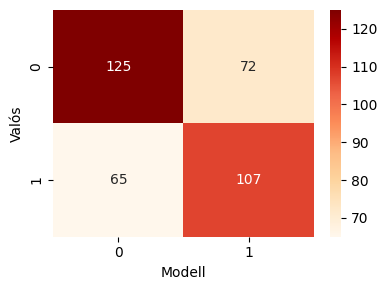


=== Ligue 1 ===
Legjobb határérték: 0.55 | Legjobb F1: 0.5971
              precision    recall  f1-score   support

           0       0.55      0.73      0.63       163
           1       0.68      0.49      0.57       189

    accuracy                           0.60       352
   macro avg       0.61      0.61      0.60       352
weighted avg       0.62      0.60      0.59       352



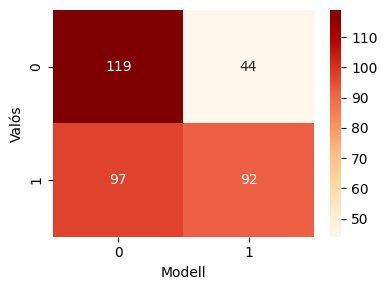


=== Serie A ===
Legjobb határérték: 0.49 | Legjobb F1: 0.6050
              precision    recall  f1-score   support

           0       0.62      0.59      0.61       182
           1       0.59      0.62      0.61       175

    accuracy                           0.61       357
   macro avg       0.61      0.61      0.61       357
weighted avg       0.61      0.61      0.61       357



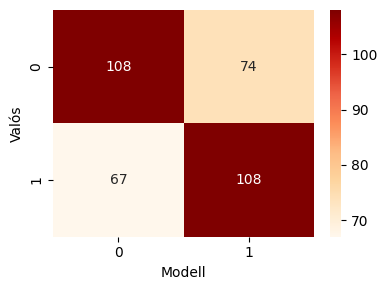


=== Bundesliga ===
Legjobb határérték: 0.56 | Legjobb F1: 0.5873
              precision    recall  f1-score   support

           0       0.47      0.60      0.53       112
           1       0.71      0.59      0.65       185

    accuracy                           0.60       297
   macro avg       0.59      0.60      0.59       297
weighted avg       0.62      0.60      0.60       297



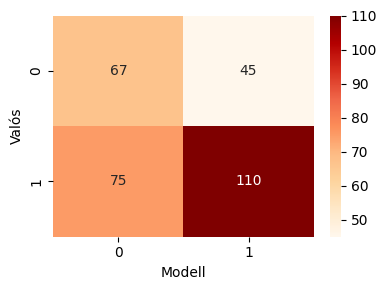

In [204]:
def generalization_underover(model, df_dict, target_col, drop_cols=[]):
    
    results = {}

    for league_name, df in df_dict.items():
        print(f"\n=== {league_name} ===")

        df_cleaned = df.dropna().reset_index(drop=True)
        
        test_size = int(len(df_cleaned) * 0.1)
        df_test = df_cleaned[-test_size:]  

        X = df_test.drop(columns=[target_col] + drop_cols)
        y = df_test[target_col]

        probs = model.predict_proba(X)
        thresholds = np.arange(0.1, 0.7, 0.01)
        f1_scores = []

        for t in thresholds:
            preds = (probs[:, 1] >= t).astype(int)
            f1_scores.append(f1_score(y, preds, average='macro'))

        best_threshold = thresholds[np.argmax(f1_scores)]
        best_f1 = max(f1_scores)

        preds = (probs[:, 1] >= best_threshold).astype(int)

        print(f"Legjobb határérték: {best_threshold:.2f} | Legjobb F1: {best_f1:.4f}")
        print(classification_report(y, preds))

        plt.figure(figsize=(4, 3))
        cm = confusion_matrix(y, preds)
        sns.heatmap(cm, annot=True, fmt="d", cmap="OrRd", xticklabels=['0', '1'], yticklabels=['0', '1'])
        plt.xlabel("Modell")
        plt.ylabel("Valós")
        plt.tight_layout()
        plt.show()

        df_result = df_test.copy()
        df_result['P_0'] = probs[:, 0]
        df_result['P_1'] = probs[:, 1]
        df_result['Predicted'] = preds

        results[league_name] = df_result

    return results


pl_dict = {
    'La Liga': la_liga,
    'Ligue 1':ligue_1,
    'Serie A':serie_a,
    'Bundesliga':bundesliga
}

drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market',
        'U2.5_odds_market', 'O2.5_odds_market']

general_pl = generalization_underover(
    model=pl_rf_uo,
    df_dict=pl_dict,
    target_col='target_o2.5',
    drop_cols=drop
)


In [205]:
def generalization_betting(df_dict, stake=1):

    results = {}

    for league_name, df in df_dict.items():
        df = df.copy() 

        df['Profit'] = df.apply(
            lambda row: (stake * row['O2.5_odds_market'] - stake) if row['Predicted'] == 1 and row['target_o2.5'] == 1 else
                         (stake * row['U2.5_odds_market'] - stake) if row['Predicted'] == 0 and row['target_o2.5'] == 0 else
                         -stake, axis=1
        )

        total_profit = df['Profit'].sum()
        total_bets = len(df)

        roi = (total_profit / (total_bets * stake)) * 100
        
        print(f"{league_name} - ROI: {roi:.2f}%")

        df_profit = df[df['target_o2.5'] == df['Predicted']]
        df_loss = df[df['target_o2.5'] != df['Predicted']]

        results[league_name] = {
            'ROI': roi,
            'df_profit': df_profit,
            'df_loss': df_loss,
            'df': df
        }

    return results

general_betting_pl = generalization_betting(general_pl, stake=1)

La Liga - ROI: 5.26%
Ligue 1 - ROI: 7.03%
Serie A - ROI: 5.80%
Bundesliga - ROI: 2.80%


## Bundesliga


=== La Liga ===
Legjobb határérték: 0.54 | Legjobb F1: 0.6099
              precision    recall  f1-score   support

           0       0.63      0.65      0.64       197
           1       0.59      0.57      0.58       172

    accuracy                           0.61       369
   macro avg       0.61      0.61      0.61       369
weighted avg       0.61      0.61      0.61       369



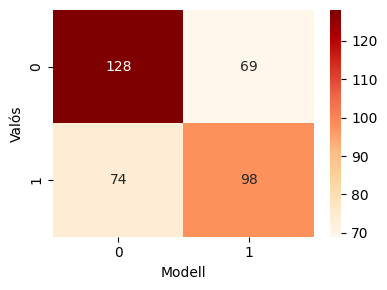


=== Ligue 1 ===
Legjobb határérték: 0.58 | Legjobb F1: 0.5677
              precision    recall  f1-score   support

           0       0.53      0.71      0.61       163
           1       0.64      0.45      0.53       189

    accuracy                           0.57       352
   macro avg       0.59      0.58      0.57       352
weighted avg       0.59      0.57      0.56       352



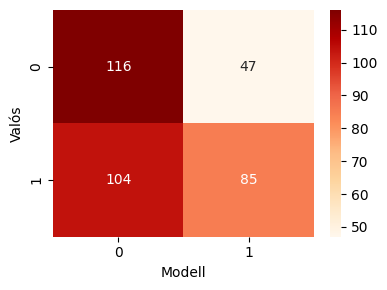


=== Serie A ===
Legjobb határérték: 0.52 | Legjobb F1: 0.6182
              precision    recall  f1-score   support

           0       0.65      0.56      0.60       182
           1       0.60      0.68      0.64       175

    accuracy                           0.62       357
   macro avg       0.62      0.62      0.62       357
weighted avg       0.62      0.62      0.62       357



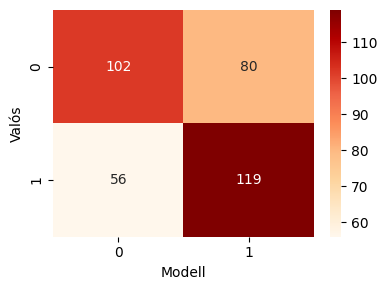


=== Premier League ===
Legjobb határérték: 0.59 | Legjobb F1: 0.5524
              precision    recall  f1-score   support

           0       0.42      0.40      0.41       129
           1       0.69      0.71      0.70       240

    accuracy                           0.60       369
   macro avg       0.55      0.55      0.55       369
weighted avg       0.59      0.60      0.60       369



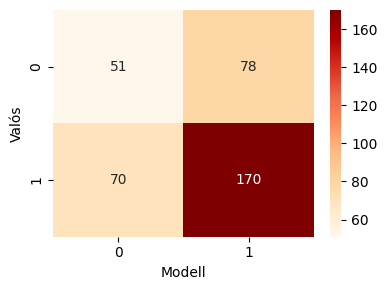

In [206]:
bundesliga_dict = {
    'La Liga': la_liga,
    'Ligue 1':ligue_1,
    'Serie A':serie_a,
    'Premier League':premier_league
}

drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market',
        'U2.5_odds_market', 'O2.5_odds_market']

general_bundesliga = generalization_underover(
    model=bl_rf_uo,
    df_dict=bundesliga_dict,
    target_col='target_o2.5',
    drop_cols=drop
)


In [207]:
general_betting_bundesliga = generalization_betting(general_bundesliga, stake=1)

La Liga - ROI: 2.23%
Ligue 1 - ROI: 1.34%
Serie A - ROI: 8.92%
Premier League - ROI: -2.14%


## Serie A


=== La Liga ===
Legjobb határérték: 0.51 | Legjobb F1: 0.6104
              precision    recall  f1-score   support

           0       0.63      0.68      0.65       197
           1       0.60      0.54      0.57       172

    accuracy                           0.62       369
   macro avg       0.61      0.61      0.61       369
weighted avg       0.61      0.62      0.61       369



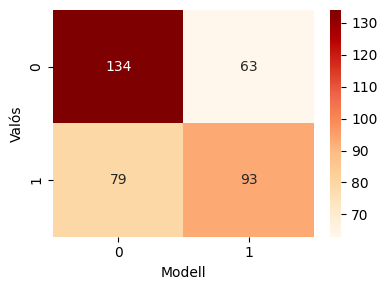


=== Ligue 1 ===
Legjobb határérték: 0.52 | Legjobb F1: 0.5614
              precision    recall  f1-score   support

           0       0.53      0.55      0.54       163
           1       0.60      0.57      0.58       189

    accuracy                           0.56       352
   macro avg       0.56      0.56      0.56       352
weighted avg       0.56      0.56      0.56       352



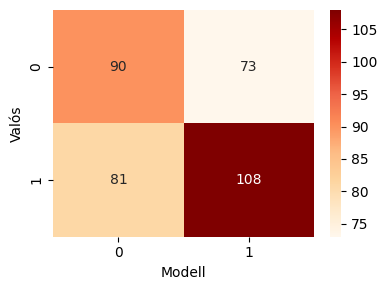


=== Bundesliga ===
Legjobb határérték: 0.59 | Legjobb F1: 0.5988
              precision    recall  f1-score   support

           0       0.48      0.62      0.54       112
           1       0.72      0.59      0.65       185

    accuracy                           0.61       297
   macro avg       0.60      0.61      0.60       297
weighted avg       0.63      0.61      0.61       297



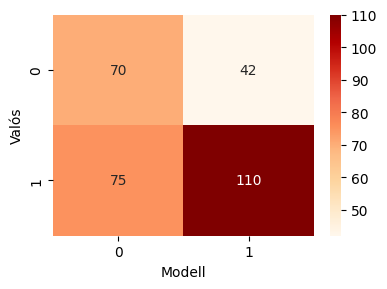


=== Premier League ===
Legjobb határérték: 0.59 | Legjobb F1: 0.5633
              precision    recall  f1-score   support

           0       0.42      0.55      0.48       129
           1       0.71      0.60      0.65       240

    accuracy                           0.58       369
   macro avg       0.57      0.57      0.56       369
weighted avg       0.61      0.58      0.59       369



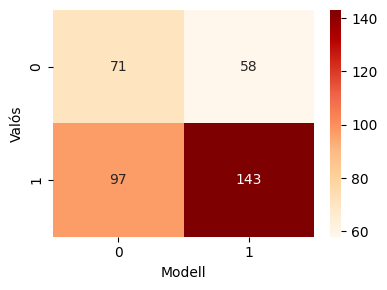

In [208]:
seriea_dict = {
    'La Liga': la_liga,
    'Ligue 1':ligue_1,
    'Bundesliga':bundesliga,
    'Premier League':premier_league
}

drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market',
        'U2.5_odds_market', 'O2.5_odds_market']

general_seriea = generalization_underover(
    model=it_rf_uo,
    df_dict=seriea_dict,
    target_col='target_o2.5',
    drop_cols=drop
)


In [209]:
general_betting_seriea = generalization_betting(general_seriea, stake=1)

La Liga - ROI: 3.13%
Ligue 1 - ROI: -2.49%
Bundesliga - ROI: 5.18%
Premier League - ROI: -1.05%


## La Liga


=== Serie A ===
Legjobb határérték: 0.48 | Legjobb F1: 0.5797
              precision    recall  f1-score   support

           0       0.59      0.59      0.59       182
           1       0.57      0.57      0.57       175

    accuracy                           0.58       357
   macro avg       0.58      0.58      0.58       357
weighted avg       0.58      0.58      0.58       357



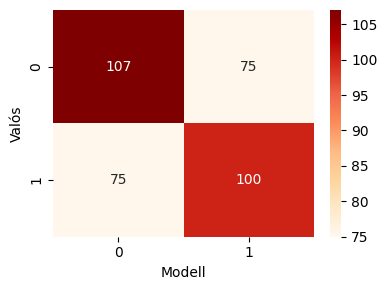


=== Ligue 1 ===
Legjobb határérték: 0.52 | Legjobb F1: 0.5369
              precision    recall  f1-score   support

           0       0.50      0.57      0.53       163
           1       0.58      0.51      0.54       189

    accuracy                           0.54       352
   macro avg       0.54      0.54      0.54       352
weighted avg       0.54      0.54      0.54       352



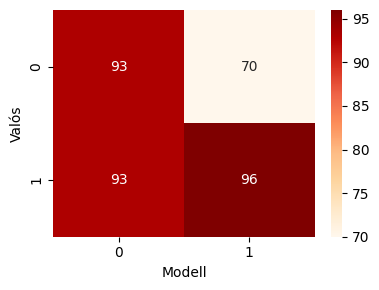


=== Bundesliga ===
Legjobb határérték: 0.58 | Legjobb F1: 0.5670
              precision    recall  f1-score   support

           0       0.46      0.50      0.48       112
           1       0.68      0.64      0.66       185

    accuracy                           0.59       297
   macro avg       0.57      0.57      0.57       297
weighted avg       0.59      0.59      0.59       297



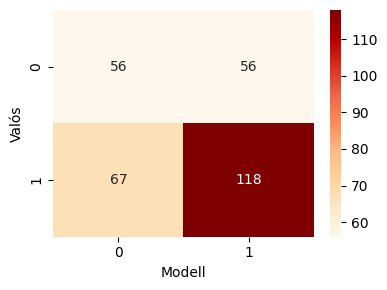


=== Premier League ===
Legjobb határérték: 0.59 | Legjobb F1: 0.5415
              precision    recall  f1-score   support

           0       0.40      0.57      0.47       129
           1       0.70      0.55      0.61       240

    accuracy                           0.55       369
   macro avg       0.55      0.56      0.54       369
weighted avg       0.60      0.55      0.56       369



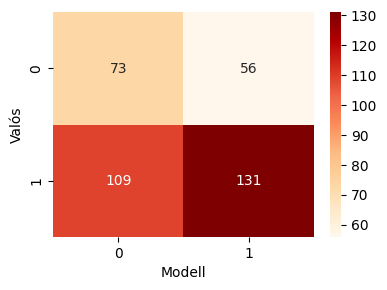

In [210]:
laliga_dict = {
    'Serie A': serie_a,
    'Ligue 1':ligue_1,
    'Bundesliga':bundesliga,
    'Premier League':premier_league
}

drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market',
        'U2.5_odds_market', 'O2.5_odds_market']

general_laliga = generalization_underover(
    model=sp_rf_uo,
    df_dict=laliga_dict,
    target_col='target_o2.5',
    drop_cols=drop
)


In [211]:
general_betting_laliga = generalization_betting(general_laliga, stake=1)

Serie A - ROI: 2.60%
Ligue 1 - ROI: -5.41%
Bundesliga - ROI: -1.55%
Premier League - ROI: -4.85%


## Ligue 1


=== Serie A ===
Legjobb határérték: 0.55 | Legjobb F1: 0.6141
              precision    recall  f1-score   support

           0       0.60      0.77      0.68       182
           1       0.67      0.47      0.55       175

    accuracy                           0.62       357
   macro avg       0.63      0.62      0.61       357
weighted avg       0.63      0.62      0.62       357



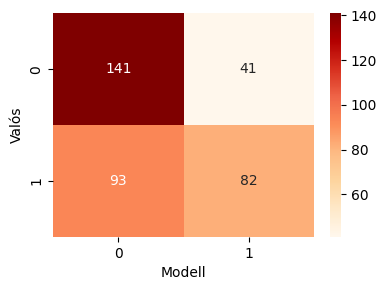


=== La Liga ===
Legjobb határérték: 0.49 | Legjobb F1: 0.6080
              precision    recall  f1-score   support

           0       0.68      0.51      0.58       197
           1       0.56      0.73      0.63       172

    accuracy                           0.61       369
   macro avg       0.62      0.62      0.61       369
weighted avg       0.63      0.61      0.61       369



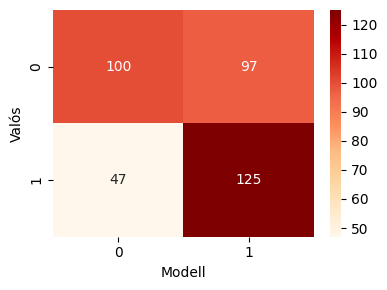


=== Bundesliga ===
Legjobb határérték: 0.57 | Legjobb F1: 0.5729
              precision    recall  f1-score   support

           0       0.47      0.48      0.47       112
           1       0.68      0.66      0.67       185

    accuracy                           0.60       297
   macro avg       0.57      0.57      0.57       297
weighted avg       0.60      0.60      0.60       297



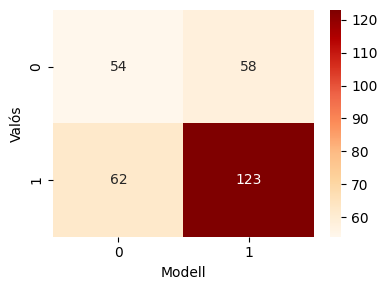


=== Premier League ===
Legjobb határérték: 0.59 | Legjobb F1: 0.5467
              precision    recall  f1-score   support

           0       0.40      0.51      0.45       129
           1       0.69      0.60      0.64       240

    accuracy                           0.57       369
   macro avg       0.55      0.55      0.55       369
weighted avg       0.59      0.57      0.58       369



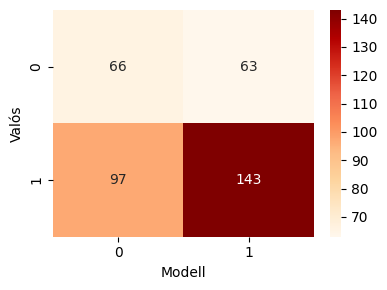

In [212]:
ligue1_dict = {
    'Serie A': serie_a,
    'La Liga':la_liga,
    'Bundesliga':bundesliga,
    'Premier League':premier_league
}

drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market',
        'U2.5_odds_market', 'O2.5_odds_market']

general_ligue1 = generalization_underover(
    model=fr_rf_uo,
    df_dict=ligue1_dict,
    target_col='target_o2.5',
    drop_cols=drop
)


In [213]:
general_betting_ligue1 = generalization_betting(general_ligue1, stake=1)

Serie A - ROI: 9.71%
La Liga - ROI: 3.27%
Bundesliga - ROI: -0.50%
Premier League - ROI: -4.33%
